In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

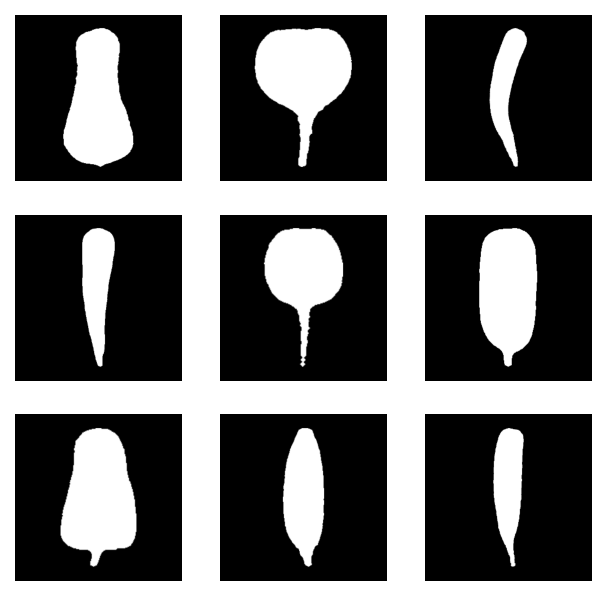

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [4]:
#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting2(func,ts,cont,of_th=0.5):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    print("span",span)
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    print(odds,[difs[i] for i in odds0])
    return odds # 

In [5]:
def testOF(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,mode=1,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,(err,trynum) = bez.fit1T(tpara=[],mode=mode,err_th=err_th,lr=lr,lrP=lrP,pat=pat,withErr=True,withEC=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return trynum,err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

def testOF1(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1(tpara=[],err_th=err_th,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

# メモ
以下の実験ではオーバフィッティング判定を0.5×平均区間長として実験しているが、停止条件となっている誤り誤差にも比例させるべきなので論文にまとめる際には、0.5 の代わりに、err_th をあてはめて結果を読み替える。

# fit1T mode 0
## img 0

^^^^.^........^.....................................................................................
........................................................................................^^^^^.^^.^..
^..................................................
CP 5.0, steps:250, etime: 36.85938 err: 4.9913307508
.......................^^^^.^.^.^....^...........
......................
CP 2.0, steps:321, etime: 46.70312 err: 1.9831941224
........................^^^^^^^^^^^.^.^.^.....................................
.................^^^^^^^^^^^^^^^^^^.....E

[] [array([1.58528944, 2.15900398, 1.6548989 , 2.9735455 , 2.53832513])]


(0.9963500998298745, array([], dtype=int64))

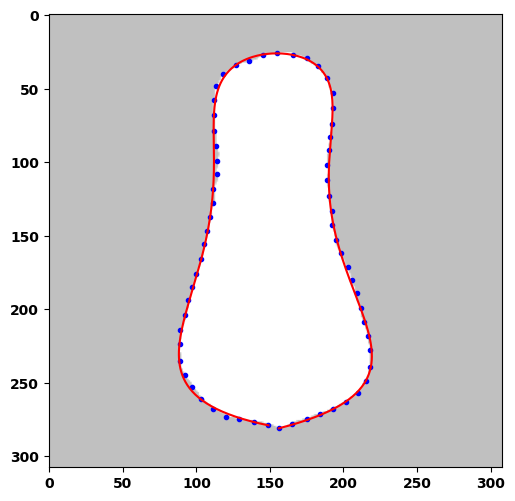

In [25]:
testOF(imgn=0,N=7,mode=0,err_th=1)

^^^.^.^.^.^..^.^....................................................................................
....................................................................................................
........................................
CP 5.0, steps:239, etime: 39.45312 err: 4.9542088165
............................................................
..........................
CP 2.0, steps:325, etime: 53.03125 err: 1.9852624075
..........................................................................
.................................................................^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^...
.^.^.^..................................^^^^^^^^^^^^^^^^^^^^^^^.....................................
.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^...^..............
CP 1.0, steps:736, etime: 115.42188 err: 0.9997849069
^.^.^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^....^.^^^^

(0.49739660406823744, array([], dtype=int64))

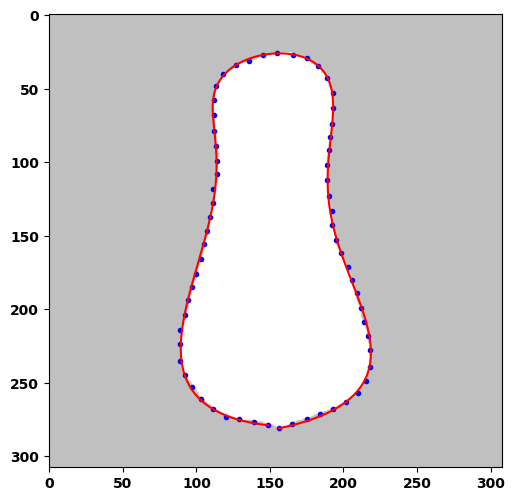

In [24]:
testOF(imgn=0,N=8,mode=0,err_th=0.5)

.....................................................................................
CP 5.0, steps:84, etime: 58.57812 err: 4.9085911684
...............
..........
CP 2.0, steps:109, etime: 74.89062 err: 1.9854089810
.....................
CP 1.0, steps:130, etime: 89.04688 err: 0.9817960167
..................
CP 0.65, steps:148, etime: 101.00000 err: 0.6443172570
.....................E

[] [array([1.83349963, 1.65517263])]


(0.4965834125046084, array([], dtype=int64))

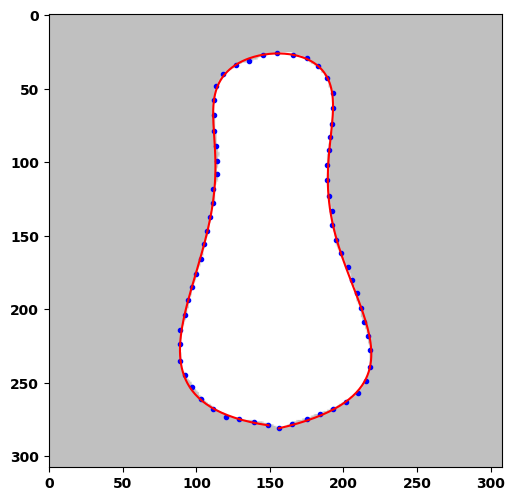

In [20]:
testOF(imgn=0,N=8,mode=1,err_th=0.5)

## img1

^^^^^^^^^.^.^..^.^..^.^^..^.^.......................................................................
.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........
^^^^^^^^^^^^^^^^^^^^^^^^^^^....^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 5.0, steps:728, etime: 131.51562 err: 4.9727005925
...........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..
..............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............^.^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(2104, 373.640625, 3.032082802786653, array([], dtype=int64))

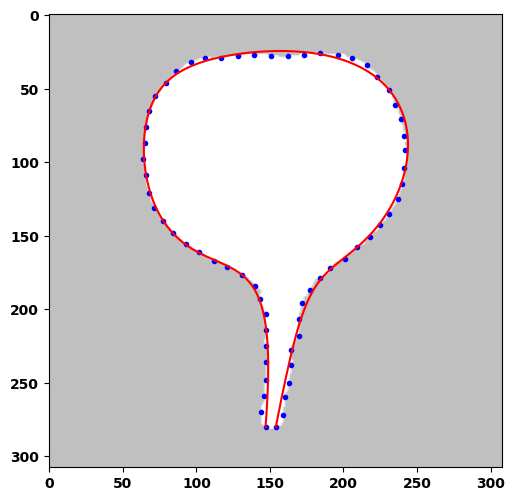

In [22]:
testOF(imgn=1,N=9,mode=0,err_th=2,of_th=2)

^^^^^^^^^.^....^^.^.^^..............^^^^....................^^^^^^^^.^^^^^..
CP 5.0, steps:75, etime: 19.89062 err: 4.9966341614
...............^^^^^^^^^
^^...^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^..............^^........^^^^^^^^^^^^..
^^^...................^.^^^^^^^^^^^^.^^.....^.^......^^^^^^^^^^^^^^^^........^.^.^.^^^^^^^^^^^^^^...
.............^.^.^^^^^^^^^^^^^..^.........................^.^^^^^^^^^^^^.^.^^^^^.......^............
.......^^^^.....^.^.^^^^^^^^^^^^^^^....^^^^^^^.....^^^^^^^...^^^^^^^...^...^^^^...^^^^^^^^^^^^^^^^^^
^....^^^^^^^^.
CP 2.0, steps:513, etime: 107.20312 err: 1.9940014773
.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^^^^.........
.....^^^^^^^^^^^^^...^^^^^^..................................^^^^^^^^^^^^^^^^^.^.^^^

(3000, 602.171875, 0.8685039663135619, array([], dtype=int64))

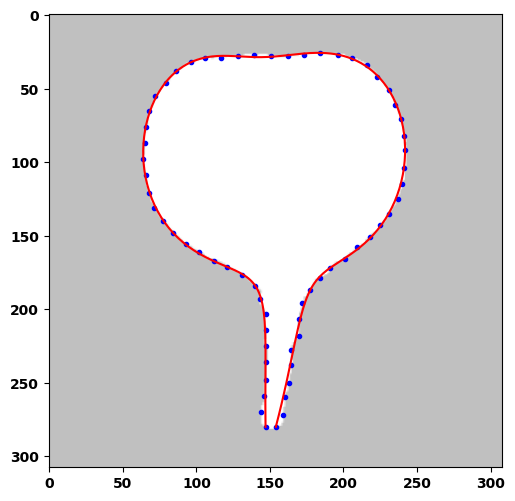

In [17]:
testOF(imgn=1,N=10,mode=0,err_th=0.65,of_th=0.65)

^^^^^^^^^.^^^.^.^.^.^...............................................................................
......................
CP 5.0, steps:121, etime: 30.79688 err: 4.9988407057
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..............................^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^..
...............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................
...........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^.^^^^^^^^^^^^...
CP 2.0, steps:726, etime: 156.56250 err: 1.9875125334
............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................

(0.9910010065477725, array([], dtype=int64))

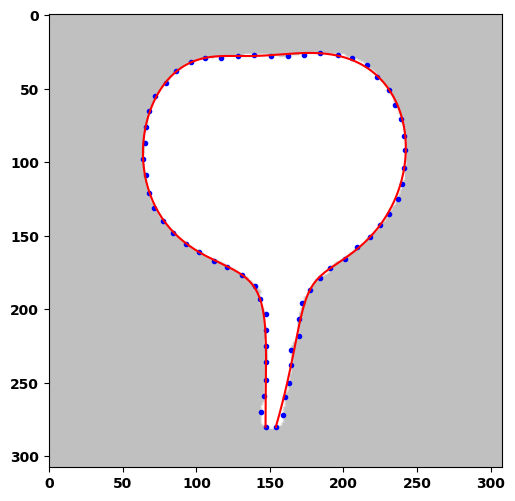

In [41]:
testOF(imgn=1,N=10,mode=0,err_th=1)

^^^^^^^^^.^^^.^.^.^.^...............................................................................
......................
CP 5.0, steps:121, etime: 31.40625 err: 4.9988407057
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..............................^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^..
...............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................
...........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^.^^^^^^^^^^^^...
CP 2.0, steps:726, etime: 162.29688 err: 1.9875125334
............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................

(0.9910010065477725, array([], dtype=int64))

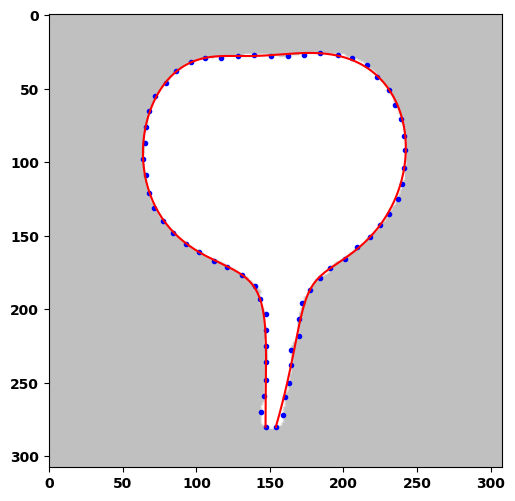

In [45]:
testOF(imgn=1,N=10,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^.^....^.^.^...........^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^....
CP 5.0, steps:120, etime: 34.29688 err: 4.9399267692
...........^^^^^^.........^^^^^^^^^............................................
.........^^^^^^^^^^^^^^^^^^.^^^..^^..^^^....^^.^^^^^^^^.^^^^^^^^^^^.^^...............^.^^^^^^^^^^^^^
^...^^^...^..^^^^.....^^^^......^.^..^^^^^^^^^^^^^^^^^^....^^^^^^.^...^^^...^..^^^^.....^^^......^.^
^^^^^^^^^^^^^^^^^^^^^.^^^.^^^^..^^..^^^^..^...^^......^^^......^^......^^^^^^^^^^^^^^^^^.....^^^^^..
............^^^.....^.^.^^^^^^^^^^^^^^..^...........^^^^^^^^^^^^^^.^.^.^.^^^^^^^^^^^^^^.^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 2.0, steps:774, etime: 186.23438 err: 1.9785478445
.^^^...^^................
..............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7129086178028862, array([], dtype=int64))

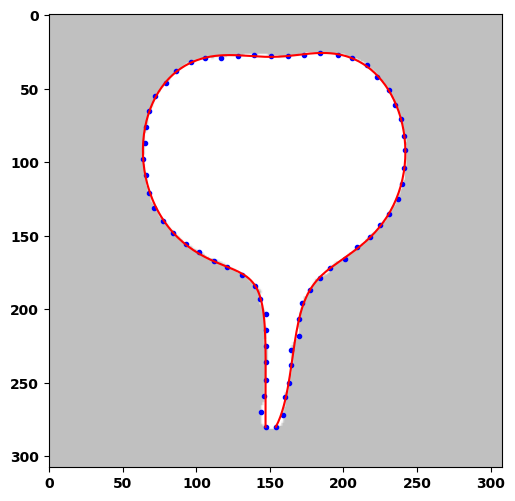

In [46]:
testOF(imgn=1,N=11,mode=0,err_th=0.5)

^^^^^^^^.^..^.^.^....^..^........................^^^^^^^^^^^^^^^.^^^..............^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^..
CP 5.0, steps:180, etime: 44.65625 err: 4.9720826635
...................
...............^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^..^.^^^^^^^^^^.^....^^^^^........^..............
......^.^^^^^^^^^^^^.^^..^^^...................................^^^^^^^^^^^^^^^.^.^......^.^.........
..............^.^.^^^^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..
CP 2.0, steps:689, etime: 157.14062 err: 1.9950800574
...^^^^^^^
................................^^^^^^^^^^^^^^^^^^^^^^^^.^^^^................^.^^^^^^^^^^^^^^^.^..^.
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 671.359375, 0.9066850308380302, array([], dtype=int64))

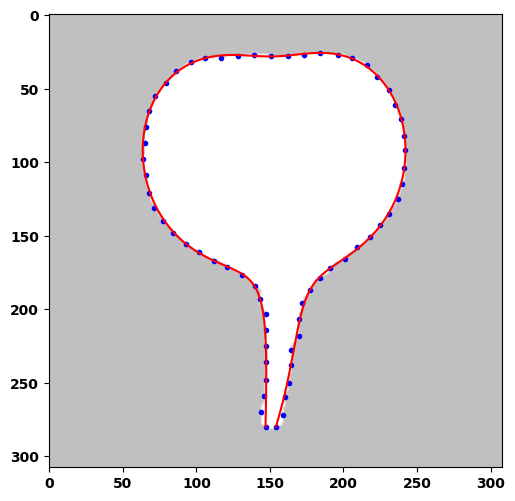

In [18]:
testOF(imgn=1,N=11,mode=0,err_th=0.65,of_th=0.65)

^^^^^^^^.^..^.^.^....^..^........................^^^^^^^^^^^^^^^.^^^..............^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^..
CP 5.0, steps:180, etime: 48.71875 err: 4.9720826635
...................
...............^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^..^.^^^^^^^^^^.^....^^^^^........^..............
......^.^^^^^^^^^^^^.^^..^^^...................................^^^^^^^^^^^^^^^.^.^......^.^.........
..............^.^.^^^^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..
CP 2.0, steps:689, etime: 173.23438 err: 1.9950800574
...^^^^^^^
................................^^^^^^^^^^^^^^^^^^^^^^^^.^^^^................^.^^^^^^^^^^^^^^^.^..^.
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7699636611107719,
 array([], dtype=int64),
 Matrix([
 [   154.0*t**11 + 208.409*t**10*(11 - 11*t) + 2719.96*t**9*(1 - t)**2 + 89071.7*t**8*(1 - t)**3 + 167082.0*t**7*(1 - t)**4 - 376328.0*t**6*(1 - t)**5 + 539176.0*t**5*(1 - t)**6 - 87299.5*t**4*(1 - t)**7 - 21244.9*t**3*(1 - t)**8 + 7939.0*t**2*(1 - t)**9 + 1649.02*t*(1 - t)**10 + 147.0*(1 - t)**11],
 [280.0*t**11 + 149.906*t**10*(11 - 11*t) - 4531.88*t**9*(1 - t)**2 + 164836.0*t**8*(1 - t)**3 - 450515.0*t**7*(1 - t)**4 + 266064.0*t**6*(1 - t)**5 + 362056.0*t**5*(1 - t)**6 - 379910.0*t**4*(1 - t)**7 + 81528.7*t**3*(1 - t)**8 + 15916.7*t**2*(1 - t)**9 + 106.838*t*(1 - t)**10 + 280.0*(1 - t)**11]]))

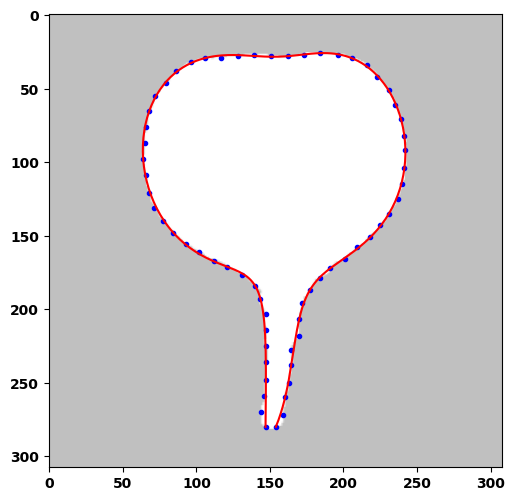

In [35]:
testOF(imgn=1,N=11,mode=0,err_th=0.65,of_th=0.65)

^^^^^^^^.^..^.^.^....^..^........................^^^^^^^^^^^^^^^.^^^..............^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^..
CP 5.0, steps:180, etime: 48.79688 err: 4.9720826635
...................
...............^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^..^.^^^^^^^^^^.^....^^^^^........^..............
......^.^^^^^^^^^^^^.^^..^^^...................................^^^^^^^^^^^^^^^.^.^......^.^.........
..............^.^.^^^^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..
CP 2.0, steps:689, etime: 173.84375 err: 1.9950800574
...^^^^^^^
................................^^^^^^^^^^^^^^^^^^^^^^^^.^^^^................^.^^^^^^^^^^^^^^^.^..^.
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7699636611107719,
 array([], dtype=int64),
 Matrix([
 [   154.0*t**11 + 208.409*t**10*(11 - 11*t) + 2719.96*t**9*(1 - t)**2 + 89071.7*t**8*(1 - t)**3 + 167082.0*t**7*(1 - t)**4 - 376328.0*t**6*(1 - t)**5 + 539176.0*t**5*(1 - t)**6 - 87299.5*t**4*(1 - t)**7 - 21244.9*t**3*(1 - t)**8 + 7939.0*t**2*(1 - t)**9 + 1649.02*t*(1 - t)**10 + 147.0*(1 - t)**11],
 [280.0*t**11 + 149.906*t**10*(11 - 11*t) - 4531.88*t**9*(1 - t)**2 + 164836.0*t**8*(1 - t)**3 - 450515.0*t**7*(1 - t)**4 + 266064.0*t**6*(1 - t)**5 + 362056.0*t**5*(1 - t)**6 - 379910.0*t**4*(1 - t)**7 + 81528.7*t**3*(1 - t)**8 + 15916.7*t**2*(1 - t)**9 + 106.838*t*(1 - t)**10 + 280.0*(1 - t)**11]]))

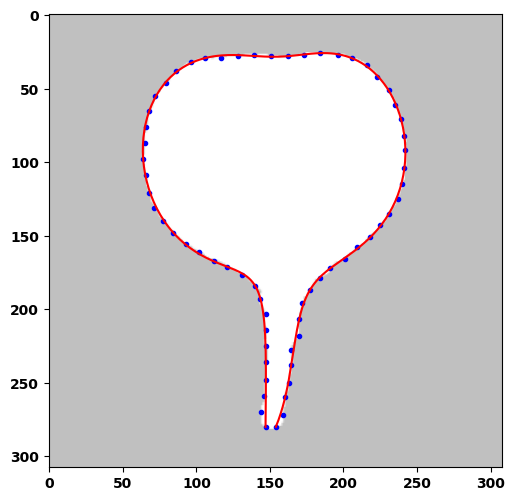

In [37]:
testOF(imgn=1,N=11,mode=0,err_th=0.65)

^^^^^^^^^^^^^^.
CP 5.0, steps:14, etime: 9.37500 err: 4.1676197870
^.^^.^..^..^..^......................................................................
....................................................................................................
...............................................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^.
CP 2.0, steps:319, etime: 90.03125 err: 1.9966429889
............^^..............................................^^^^^^^^^^^^^^^^^^^^
.^^^^.^^^^^........^^....................^.^^^^^^^^^^^^^^^^.^.^.^.^.^.^^^...........................
.......^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................^^^^^^^^^^^^
^^^^^....^........^^^^^^^^^^^.
CP 1.0, steps:629, etime: 172.17188 err: 0.9390680465
^^....^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6251058259698212,
 array([], dtype=int64),
 Matrix([
 [         154.0*t**12 + 220.469*t**11*(12 - 12*t) + 746.539*t**10*(1 - t)**2 + 105646.0*t**9*(1 - t)**3 + 216353.0*t**8*(1 - t)**4 - 109912.0*t**7*(1 - t)**5 + 149103.0*t**6*(1 - t)**6 + 382670.0*t**5*(1 - t)**7 - 147942.0*t**4*(1 - t)**8 - 2077.33*t**3*(1 - t)**9 + 13908.2*t**2*(1 - t)**10 + 1662.65*t*(1 - t)**11 + 147.0*(1 - t)**12],
 [280.0*t**12 + 48.5825*t**11*(12 - 12*t) + 42088.3*t**10*(1 - t)**2 - 334070.0*t**9*(1 - t)**3 + 2.26256e+6*t**8*(1 - t)**4 - 6.78459e+6*t**7*(1 - t)**5 + 9.78144e+6*t**6*(1 - t)**6 - 6.87249e+6*t**5*(1 - t)**7 + 2.31083e+6*t**4*(1 - t)**8 - 334545.0*t**3*(1 - t)**9 + 43379.3*t**2*(1 - t)**10 + 305.6*t*(1 - t)**11 + 280.0*(1 - t)**12]]))

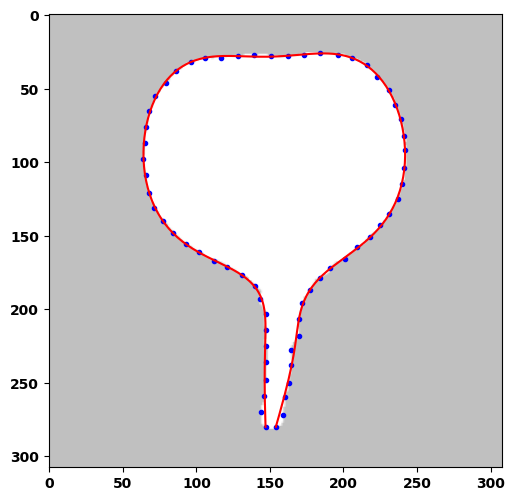

In [66]:
testOF(imgn=1,N=12,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^^^^.
CP 5.0, steps:14, etime: 8.42188 err: 4.1676197870
^.^^.^..^..^..^......................................................................
....................................................................................................
...............................................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^.
CP 2.0, steps:319, etime: 85.64062 err: 1.9966429889
............^^..............................................^^^^^^^^^^^^^^^^^^^^
.^^^^.^^^^^........^^....................^.^^^^^^^^^^^^^^^^.^.^.^.^.^.^^^...........................
.......^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................^^^^^^^^^^^^
^^^^^....^........^^^^^^^^^^^.
CP 1.0, steps:629, etime: 164.39062 err: 0.9390680465
^^....^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6481400868990989, array([], dtype=int64))

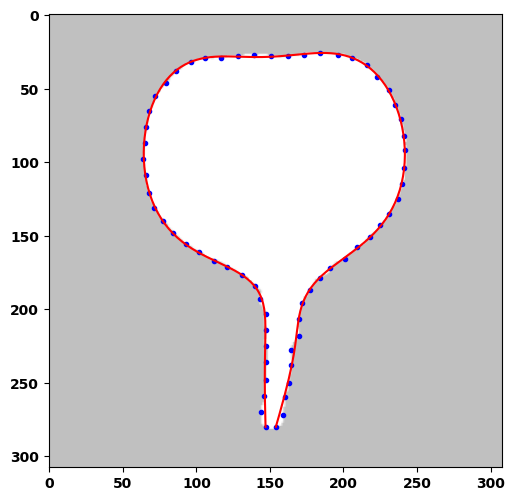

In [9]:
testOF(imgn=1,N=12,mode=0,err_th=0.65)

^^^^^^^^^^^^^^.
CP 5.0, steps:14, etime: 11.04688 err: 4.3159482775
^.^^.^^.^..^..^......................................................................
^^^^^^^^^.^^^..................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^......^..................
.^^^^^^^^^^^^^^^^^^^^^^^^.^^^^....^^^...................^.^^^^^^^^^^^^^^^^....^...^^^...............
........^..^^^^^^^^^^^^^..^^..........^..............................^^^^^^^^^^^^^^^^^^........^^^..
....................................^^^^^^^^^^^^^^^^^^^...^.^.^^^....
CP 2.0, steps:468, etime: 128.29688 err: 1.9967557516
...............................
......^^^^^^^^^^^^^^^^^.^.^..^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..............................^^^^^
^^^....^^^^^^^^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:674, etime: 180.93750 err: 0.9587210613
.........................
...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6612628448041215, array([], dtype=int64))

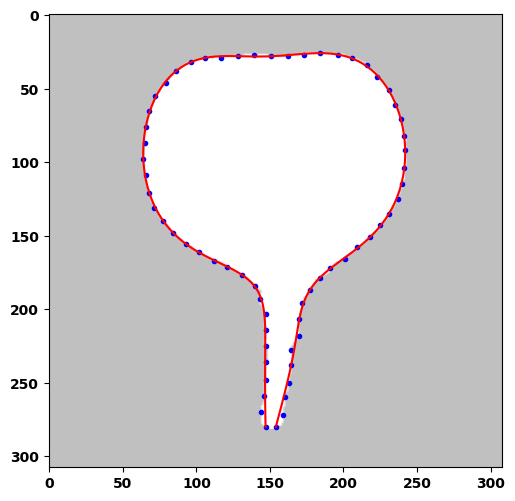

In [48]:
testOF(imgn=1,N=12,mode=0,err_th=0.5)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 12.89062 err: 4.4669081932
^.^..^..^..^..^^.....................................................................
....................................................................................................
.................................................
CP 2.0, steps:248, etime: 80.79688 err: 1.9978494621
..........................^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............................................^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 1.0, steps:655, etime: 200.51562 err: 0.9811797672
......^^^^^^^^^^^^^^^^^^^...................
.........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7097518002604921, array([58, 59, 60, 62, 63], dtype=int64))

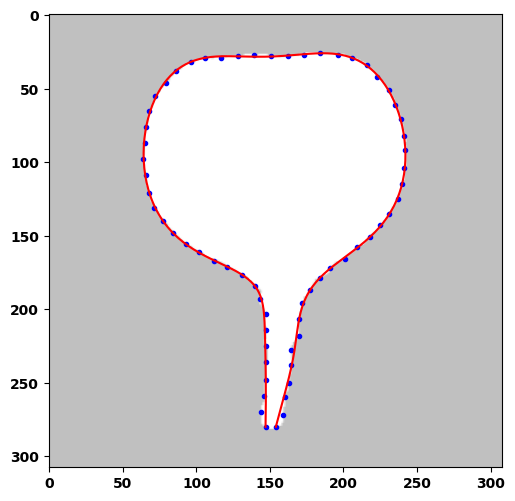

In [49]:
testOF(imgn=1,N=13,mode=0,err_th=0.5)

^^^^^^^.
CP 5.0, steps:7, etime: 7.14062 err: 4.3475397404
^^^^^^.^.^^.^^.^..^..^........................^^^^^^^^^^^^...................^^^^^^^^^^^^^^^
^......................^^^^^^^^^^^.^^...
CP 2.0, steps:139, etime: 45.73438 err: 1.9975316584
.^.........................^^^^^^^^^^^^^^^^^........^^^.....
....................^^^^^^^^^^^^^^^^.^.........^............................^^^^^^^^^^^^^^^^^......^
..^...............................^^^^^^^^^^^^^^^^.^.^..^..^...............................^^^^^^^^^
^^^^^^.^.^.^.^.^^..^.............................^^^^^^^^^^^^^^^^^.^.^.^^^^.^.^.^^.^.^.^..^.^.......
.......^^^^^^^^^^^^^^^^^^^^^^............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....
CP 1.0, steps:759, etime: 225.03125 err: 0.9967783522
..................^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6393834184711235,
 array([], dtype=int64),
 Matrix([
 [154.0*t**13 + 165.446*t**12*(13 - 13*t) + 20842.8*t**11*(1 - t)**2 - 130599.0*t**10*(1 - t)**3 + 1.73315e+6*t**9*(1 - t)**4 - 4.45018e+6*t**8*(1 - t)**5 + 8.45591e+6*t**7*(1 - t)**6 - 7.99114e+6*t**6*(1 - t)**7 + 4.91947e+6*t**5*(1 - t)**8 - 1.49172e+6*t**4*(1 - t)**9 + 185220.0*t**3*(1 - t)**10 + 9524.28*t**2*(1 - t)**11 + 1819.05*t*(1 - t)**12 + 147.0*(1 - t)**13],
 [  280.0*t**13 + 265.835*t**12*(13 - 13*t) + 11817.0*t**11*(1 - t)**2 - 132738.0*t**10*(1 - t)**3 + 1.36142e+6*t**9*(1 - t)**4 - 2.63532e+6*t**8*(1 - t)**5 - 765307.0*t**7*(1 - t)**6 + 6.87618e+6*t**6*(1 - t)**7 - 6.76552e+6*t**5*(1 - t)**8 + 2.57993e+6*t**4*(1 - t)**9 - 348040.0*t**3*(1 - t)**10 + 38634.5*t**2*(1 - t)**11 + 1624.53*t*(1 - t)**12 + 280.0*(1 - t)**13]]))

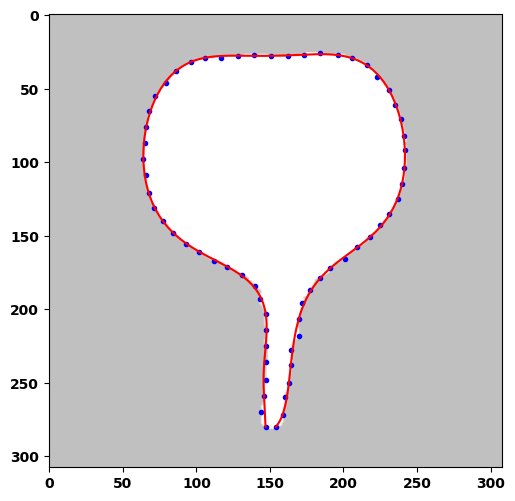

In [65]:
testOF(imgn=1,N=13,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 10.70312 err: 3.2252752234
^.
CP 2.0, steps:16, etime: 11.37500 err: 1.5550908237
^^^^.^..^..^^.^^...................................................................
........^^^^^^^^^^^^^.............................................^^^^^^^^^^..^....^....^^..........
..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:246, etime: 89.65625 err: 0.9612397899
..^^^^^^^^^^^^^^^^....^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7978410440043054,
 array([], dtype=int64),
 Matrix([
 [     154.0*t**14 + 191.178*t**13*(14 - 14*t) + 16109.7*t**12*(1 - t)**2 - 20068.9*t**11*(1 - t)**3 + 882662.0*t**10*(1 - t)**4 + 363249.0*t**9*(1 - t)**5 - 3.20612e+6*t**8*(1 - t)**6 + 1.01015e+7*t**7*(1 - t)**7 - 1.04045e+7*t**6*(1 - t)**8 + 6.43979e+6*t**5*(1 - t)**9 - 2.05179e+6*t**4*(1 - t)**10 + 321146.0*t**3*(1 - t)**11 + 1129.91*t**2*(1 - t)**12 + 2212.06*t*(1 - t)**13 + 147.0*(1 - t)**14],
 [280.0*t**14 + 185.412*t**13*(14 - 14*t) - 7629.33*t**12*(1 - t)**2 + 595035.0*t**11*(1 - t)**3 - 4.98025e+6*t**10*(1 - t)**4 + 2.45546e+7*t**9*(1 - t)**5 - 6.21056e+7*t**8*(1 - t)**6 + 8.30048e+7*t**7*(1 - t)**7 - 5.87579e+7*t**6*(1 - t)**8 + 2.16245e+7*t**5*(1 - t)**9 - 3.90903e+6*t**4*(1 - t)**10 + 433020.0*t**3*(1 - t)**11 + 4053.12*t**2*(1 - t)**12 + 2050.33*t*(1 - t)**13 + 280.0*(1 - t)**14]]))

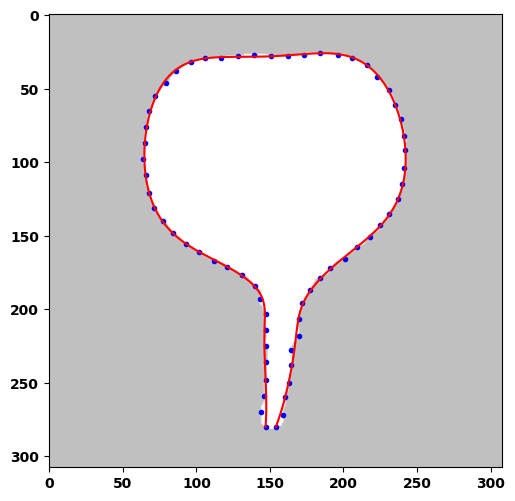

In [36]:
testOF(imgn=1,N=14,mode=0,err_th=0.65)

^^^^^^^^^^^^^
CP 5.0, steps:12, etime: 13.81250 err: 4.9545001265
^^^...
CP 2.0, steps:18, etime: 15.65625 err: 1.9623542923
^.^^.^^..^^.........................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^.^^^^^^^^^^^^^^^^^^^......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^........
CP 1.0, steps:208, etime: 75.59375 err: 0.9940987723
............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........................^.^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^..^^...........^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^..^^^^..
CP 0.65, steps:554, etime: 185.40625 err: 0.6474662258
..^^^^^^^^^......^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5959720790365336, array([55], dtype=int64))

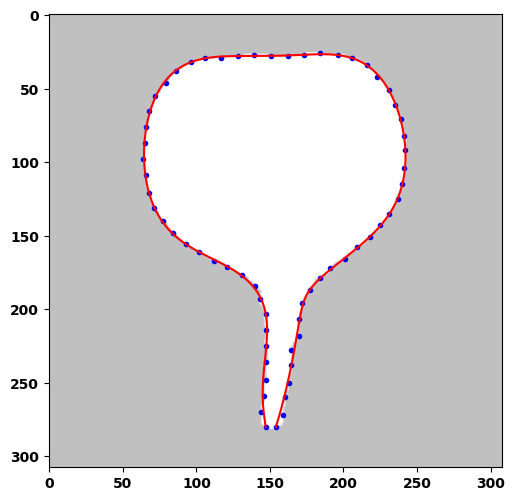

In [50]:
testOF(imgn=1,N=14,mode=0,err_th=0.5)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 9.71875 err: 3.2252752234
^.
CP 2.0, steps:16, etime: 10.34375 err: 1.5550908237
^^^^.^..^..^^.^^...................................................................
........^^^^^^^^^^^^^.............................................^^^^^^^^^^..^....^....^^..........
..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:246, etime: 82.62500 err: 0.9612397899
..^^^^^^^^^^^^^^^^....^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7978410440043054,
 array([], dtype=int64),
 Matrix([
 [     154.0*t**14 + 191.178*t**13*(14 - 14*t) + 16109.7*t**12*(1 - t)**2 - 20068.9*t**11*(1 - t)**3 + 882662.0*t**10*(1 - t)**4 + 363249.0*t**9*(1 - t)**5 - 3.20612e+6*t**8*(1 - t)**6 + 1.01015e+7*t**7*(1 - t)**7 - 1.04045e+7*t**6*(1 - t)**8 + 6.43979e+6*t**5*(1 - t)**9 - 2.05179e+6*t**4*(1 - t)**10 + 321146.0*t**3*(1 - t)**11 + 1129.91*t**2*(1 - t)**12 + 2212.06*t*(1 - t)**13 + 147.0*(1 - t)**14],
 [280.0*t**14 + 185.412*t**13*(14 - 14*t) - 7629.33*t**12*(1 - t)**2 + 595035.0*t**11*(1 - t)**3 - 4.98025e+6*t**10*(1 - t)**4 + 2.45546e+7*t**9*(1 - t)**5 - 6.21056e+7*t**8*(1 - t)**6 + 8.30048e+7*t**7*(1 - t)**7 - 5.87579e+7*t**6*(1 - t)**8 + 2.16245e+7*t**5*(1 - t)**9 - 3.90903e+6*t**4*(1 - t)**10 + 433020.0*t**3*(1 - t)**11 + 4053.12*t**2*(1 - t)**12 + 2050.33*t*(1 - t)**13 + 280.0*(1 - t)**14]]))

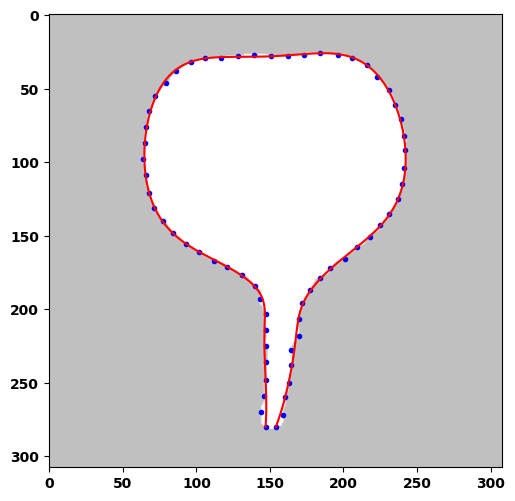

In [64]:
testOF(imgn=1,N=14,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^^
CP 5.0, steps:11, etime: 9.59375 err: 3.3622083688
^^^^^^.
CP 2.0, steps:18, etime: 11.87500 err: 1.5746446746
.^.
CP 1.0, steps:21, etime: 12.85938 err: 0.9766661563
^^.^..^..^....................................................................
............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^..^^^.................
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^....E



(0.6484297019985873, array([], dtype=int64))

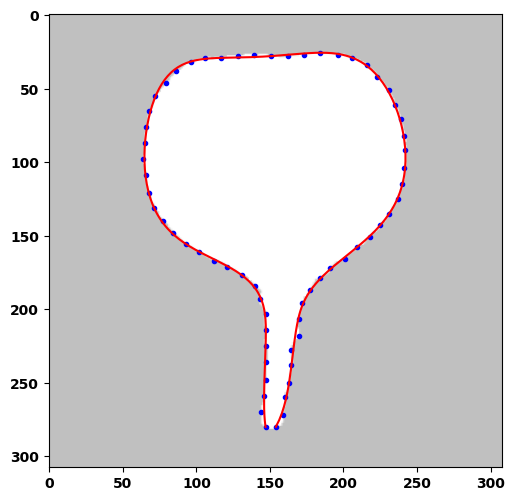

In [6]:
testOF(imgn=1,N=15,mode=0,err_th=0.65)

^^^^^^^^^^^^
CP 5.0, steps:11, etime: 9.35938 err: 3.3622083688
^^^^^^.
CP 2.0, steps:18, etime: 11.67188 err: 1.5746446746
.^.
CP 1.0, steps:21, etime: 12.67188 err: 0.9766661563
^^.^..^..^....................................................................
............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^..^^^.................
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^....
CP 0.65, steps:415, etime: 147.18750 err: 0.6484297020
..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^...................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........E



(0.49971564965267323, array([], dtype=int64))

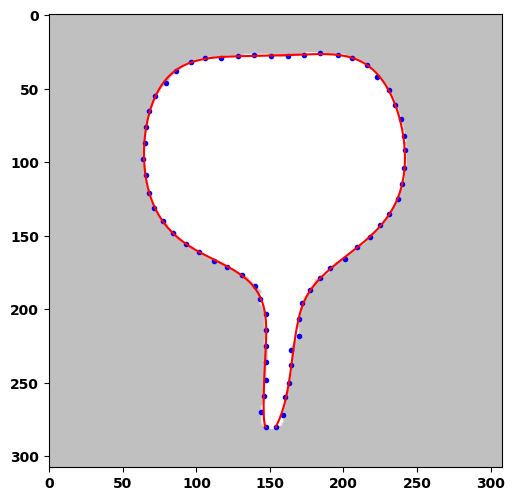

In [11]:
testOF(imgn=1,N=15,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^
CP 5.0, steps:7, etime: 16.03125 err: 3.3208907416
^.^^^^^^.
CP 2.0, steps:16, etime: 19.31250 err: 1.1562886628
^^^^.^^.
CP 1.0, steps:24, etime: 22.25000 err: 0.9893758964
^^.^^..^..^................................................................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^..
...........
CP 0.65, steps:210, etime: 92.01562 err: 0.6490709106
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
...............^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^.^^^.E

[] [array([1.81612488, 1.78639425, 2.27695954, 2.47626088, 1.76581021,
       3.79200591])]


(0.4941774550998047, array([], dtype=int64))

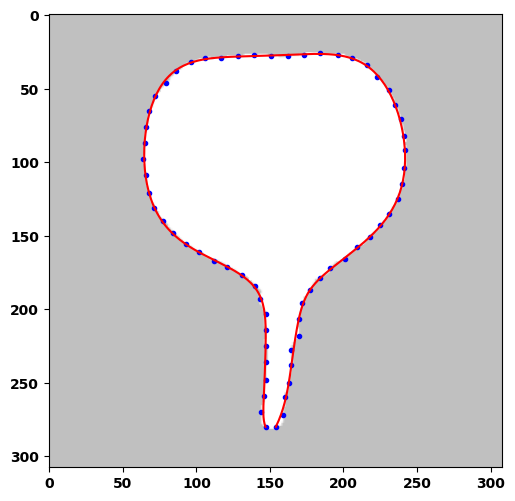

In [54]:
testOF(imgn=1,N=16,mode=0,err_th=0.5)

## img 2

^^^^^.^.^.^.^^.^.^..^............
CP 5.0, steps:32, etime: 8.32812 err: 4.9919460541
...................................................................
...........^^^^^^.^^..^....................................................^^^^^^^.^^.^^.^.^........
..
CP 2.0, steps:201, etime: 34.85938 err: 1.9971924287
.................................^^^^^^^^^.^^^^.^.^.^.^......................................^^^^^
^^^^^^^^^.^.^.^.^.^........................................^^^^^^^^^^^^^^^.^.^.^.......^.^..........
..............................^^^^^^^^^^^^^^^^.^.^.^................................................
.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^....................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^^.^..^^.^.......................
^^^^^^^^^^^^^^^^^.^.^..^.^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^.^^.^^^^^^^^^^^^^^^^.^^^^^.^^^^^.^^^^^.^^^^^^^^^^^^^^^.^^.^^.^^^^^^^^^^^^^^^^^^^^

(1.1209206440102608,
 array([], dtype=int64),
 Matrix([
 [167.0*t**8 + 81.609*t**7*(8 - 8*t) + 6143.36*t**6*(1 - t)**2 - 1028.4*t**5*(1 - t)**3 + 4758.05*t**4*(1 - t)**4 + 29591.1*t**3*(1 - t)**5 - 1037.11*t**2*(1 - t)**6 + 1471.73*t*(1 - t)**7 + 171.0*(1 - t)**8],
 [281.0*t**8 + 145.67*t**7*(8 - 8*t) + 5528.43*t**6*(1 - t)**2 + 31591.6*t**5*(1 - t)**3 - 66705.8*t**4*(1 - t)**4 + 40078.6*t**3*(1 - t)**5 - 6901.2*t**2*(1 - t)**6 + 1991.63*t*(1 - t)**7 + 277.0*(1 - t)**8]]))

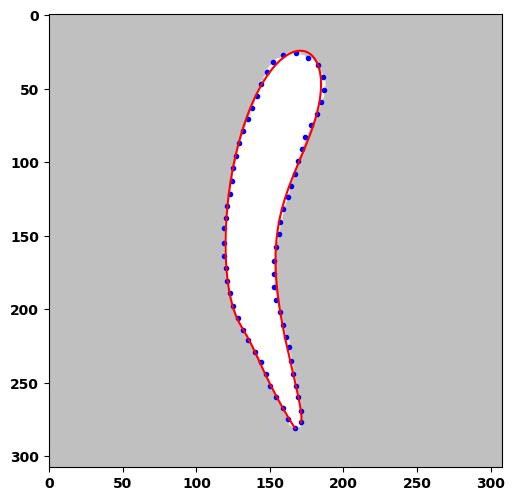

In [47]:
testOF(imgn=2,N=8,mode=0,err_th=1.0,of_th=1.0)

^^^^^^^^.^^..^....
CP 5.0, steps:17, etime: 7.73438 err: 3.3974458507
^.^..^.....^......................................................................
....................................................................................................
.........................................................
CP 2.0, steps:256, etime: 54.92188 err: 1.9981058692
..................^^^^^^^^^^^^^^^^^^^^^^^..
................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................^^^^^^^^^^^^^^^^^^^^^^.....................
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^^^.^^.^^..^..^......^^^^^^^^^^^^^^^^^^^^^..^.^...........^^^^^^
^^^^^^^^^^...^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.9998681896851572,
 array([0], dtype=int64),
 Matrix([
 [167.0*t**9 + 143.782*t**8*(9 - 9*t) - 4826.37*t**7*(1 - t)**2 + 62243.3*t**6*(1 - t)**3 - 99209.2*t**5*(1 - t)**4 + 124608.0*t**4*(1 - t)**5 - 4365.68*t**3*(1 - t)**6 + 3318.36*t**2*(1 - t)**7 + 1761.26*t*(1 - t)**8 + 171.0*(1 - t)**9],
 [ 281.0*t**9 + 229.092*t**8*(9 - 9*t) - 4042.88*t**7*(1 - t)**2 + 35591.9*t**6*(1 - t)**3 - 14042.2*t**5*(1 - t)**4 - 45187.8*t**4*(1 - t)**5 + 41894.0*t**3*(1 - t)**6 - 6831.79*t**2*(1 - t)**7 + 3137.52*t*(1 - t)**8 + 277.0*(1 - t)**9]]))

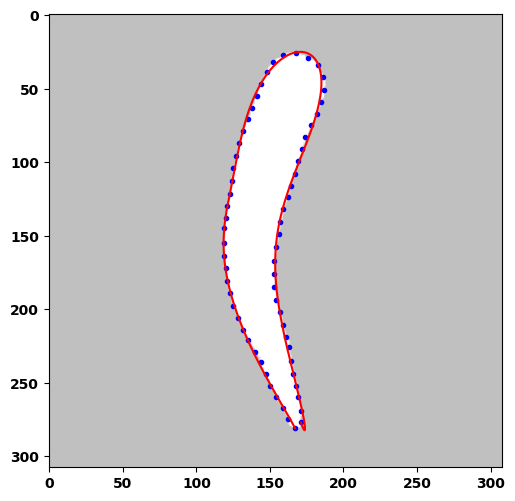

In [43]:
testOF(imgn=2,N=9,mode=0,err_th=1.0,of_th=1.0)

^^^^^^^^.^^..^....
CP 5.0, steps:17, etime: 7.75000 err: 3.3974458507
^.^..^.....^......................................................................
....................................................................................................
.........................................................
CP 2.0, steps:256, etime: 56.85938 err: 1.9981058692
..................^^^^^^^^^^^^^^^^^^^^^^^..
................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................^^^^^^^^^^^^^^^^^^^^^^.....................
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^^^.^^.^^..^..^......^^^^^^^^^^^^^^^^^^^^^..^.^...........^^^^^^
^^^^^^^^^^...^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3868, 0.49832018675328765, array([], dtype=int64))

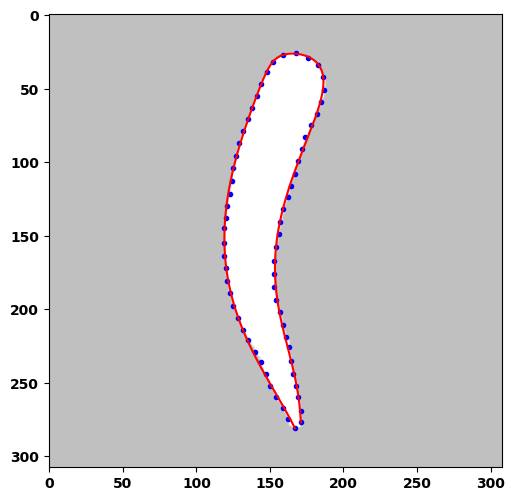

In [67]:
testOF(imgn=2,N=9,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^.^^..^....
CP 5.0, steps:17, etime: 7.42188 err: 3.3974458507
^.^..^.....^......................................................................
....................................................................................................
.........................................................
CP 2.0, steps:256, etime: 52.84375 err: 1.9981058692
..................^^^^^^^^^^^^^^^^^^^^^^^..
................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................^^^^^^^^^^^^^^^^^^^^^^.....................
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^^^.^^.^^..^..^......^^^^^^^^^^^^^^^^^^^^^..^.^...........^^^^^^
^^^^^^^^^^...^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1395, 0.9998681896851572, array([0], dtype=int64))

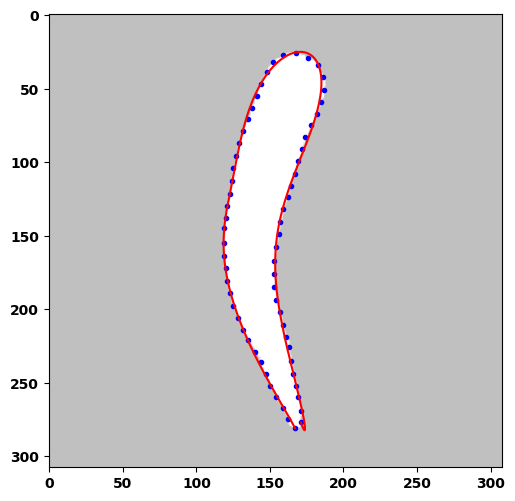

In [72]:
testOF(imgn=2,N=9,mode=0,err_th=1,of_th=1.0)

^^^^^.^.^^^^^^.^.^..
CP 5.0, steps:19, etime: 8.32812 err: 4.2559491509
^..^............................................................................
..................^^^^^^^^^.^^..^^............................................^^^^^^^^.
CP 2.0, steps:186, etime: 41.18750 err: 1.9954706407
^^.^^.^......
.....................................^^^^^^^^^^^^.^^^..^.^........................................^^
^^^.^^^^.^^^^.^.^................................................^^^^^^^^^^^^^^^.^.^^.^.^^.^^^^.^^.^
^^^.^^.^^.^..^.^^.^^.^^.^..^..^..^^^^^^^^^^^^^^^^^^..^.^.^............................^^^^^^^^^^^^^^
^................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........^...^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
^^^^.^^.
CP 1.0, steps:807, etime: 163.82812 err: 0.9814168736
^^.^^.^^.^^.^^.^^^.^..^

(0.643630157100576, array([], dtype=int64))

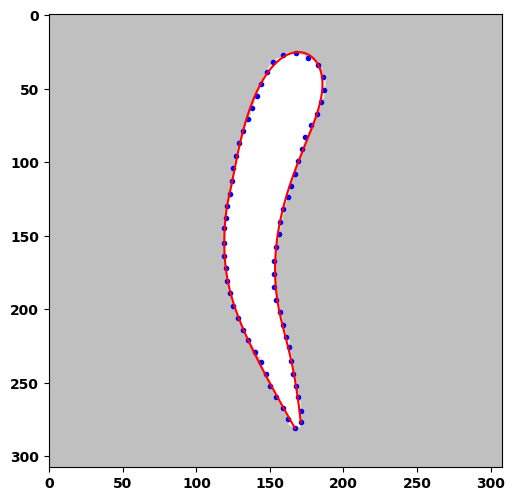

In [7]:
testOF(imgn=2,N=10,mode=0,err_th=0.65)

^^^^^.^.^^^^^^.^.^..
CP 5.0, steps:19, etime: 8.26562 err: 4.2559491509
^..^............................................................................
..................^^^^^^^^^.^^..^^............................................^^^^^^^^.
CP 2.0, steps:186, etime: 42.81250 err: 1.9954706407
^^.^^.^......
.....................................^^^^^^^^^^^^.^^^..^.^........................................^^
^^^.^^^^.^^^^.^.^................................................^^^^^^^^^^^^^^^.^.^^.^.^^.^^^^.^^.^
^^^.^^.^^.^..^.^^.^^.^^.^..^..^..^^^^^^^^^^^^^^^^^^..^.^.^............................^^^^^^^^^^^^^^
^................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........^...^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
^^^^.^^.E
[] [array([1.73217097, 2.00622345, 1.91554409, 2.40381129])] (array([30, 32,

(0.9814168735845095,
 array([], dtype=int64),
 Matrix([
 [  167.0*t**10 + 83.7585*t**9*(10 - 10*t) + 6002.22*t**8*(1 - t)**2 + 5969.14*t**7*(1 - t)**3 + 89195.5*t**6*(1 - t)**4 - 142911.0*t**5*(1 - t)**5 + 212051.0*t**4*(1 - t)**6 - 20916.2*t**3*(1 - t)**7 + 7798.0*t**2*(1 - t)**8 + 1691.49*t*(1 - t)**9 + 171.0*(1 - t)**10],
 [281.0*t**10 + 124.511*t**9*(10 - 10*t) + 14035.8*t**8*(1 - t)**2 - 72871.9*t**7*(1 - t)**3 + 404161.0*t**6*(1 - t)**4 - 605684.0*t**5*(1 - t)**5 + 364114.0*t**4*(1 - t)**6 - 91794.9*t**3*(1 - t)**7 + 15804.4*t**2*(1 - t)**8 + 2047.01*t*(1 - t)**9 + 277.0*(1 - t)**10]]))

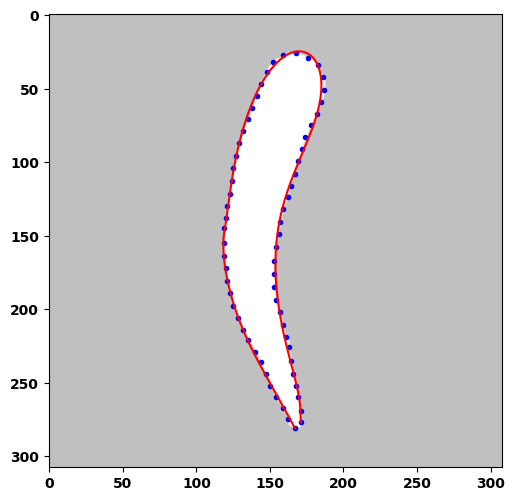

In [48]:
testOF(imgn=2,N=10,mode=0,err_th=1.0,of_th=1.0)

^^^^^.^.^^^^^^.^.^..
CP 5.0, steps:19, etime: 8.71875 err: 4.2559491509
^..^............................................................................
..................^^^^^^^^^.^^..^^............................................^^^^^^^^.
CP 2.0, steps:186, etime: 45.82812 err: 1.9954706407
^^.^^.^......
.....................................^^^^^^^^^^^^.^^^..^.^........................................^^
^^^.^^^^.^^^^.^.^................................................^^^^^^^^^^^^^^^.^.^^.^.^^.^^^^.^^.^
^^^.^^.^^.^..^.^^.^^.^^.^..^..^..^^^^^^^^^^^^^^^^^^..^.^.^............................^^^^^^^^^^^^^^
^................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........^...^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
^^^^.^^.
CP 1.0, steps:807, etime: 179.64062 err: 0.9814168736
^^.^^.^^.^^.^^.^^^.^..^

(1433, 0.643630157100576, array([], dtype=int64))

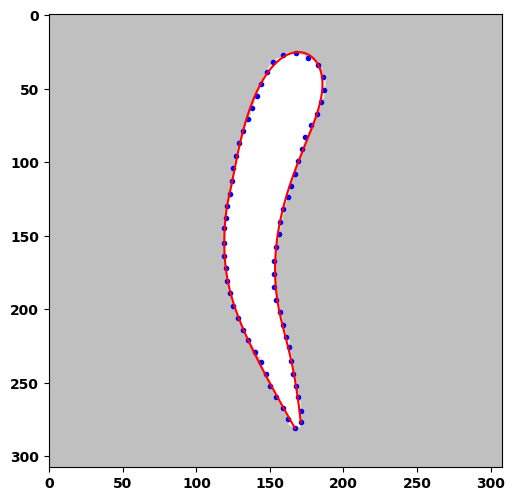

In [65]:
testOF(imgn=2,N=10,mode=0,err_th=0.65,of_th=0.65)

## img 3

^^^.^.^.^.^..^.^....................................................................................
....................................................................................................
......................................................
CP 5.0, steps:253, etime: 24.28125 err: 4.9700105146
..............................................
.......................................................................................
CP 2.0, steps:386, etime: 36.53125 err: 1.9900520603
.............
....................................................................................................
.....................................................E



(0.9996392121361694, array([], dtype=int64))

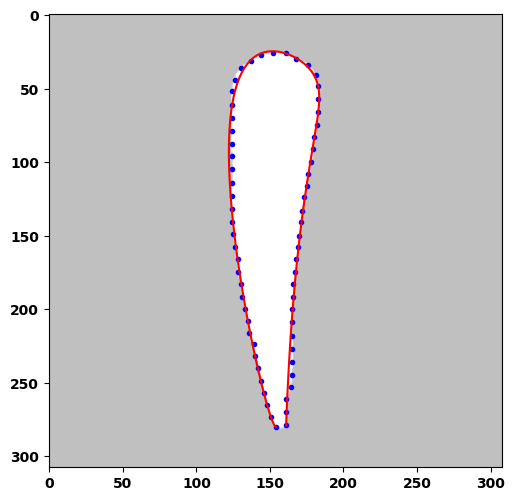

In [14]:
testOF(imgn=3,N=5,mode=0,err_th=1)

^^^.^.^.^.^..^.^....................................................................................
....................................................................................................
......................................................
CP 5.0, steps:253, etime: 27.00000 err: 4.9700105146
..............................................
.......................................................................................
CP 2.0, steps:386, etime: 40.18750 err: 1.9900520603
.............
....................................................................................................
.....................................................E
[] [array([1.64550197, 1.94070137, 2.3162655 , 1.98000236, 1.68039608])] (array([ 3, 34, 35, 36, 37], dtype=int64),) span 8.909502355381846


(0.9996392121361694,
 array([], dtype=int64),
 Matrix([
 [ 154.0*t**5 + 140.091*t**4*(5 - 5*t) + 154.655*t**3*(1 - t)**2 + 2710.3*t**2*(1 - t)**3 + 886.917*t*(1 - t)**4 + 161.0*(1 - t)**5],
 [280.0*t**5 + 275.279*t**4*(5 - 5*t) - 3306.45*t**3*(1 - t)**2 + 3026.75*t**2*(1 - t)**3 - 862.259*t*(1 - t)**4 + 279.0*(1 - t)**5]]))

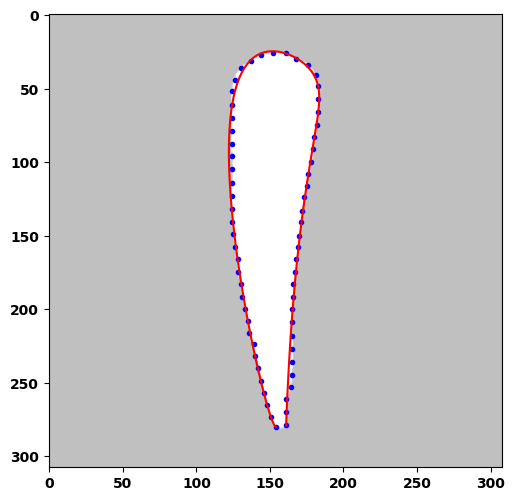

In [44]:
testOF(imgn=3,N=5,mode=0,err_th=1.0,of_th=1.0)

^^^.^.^.^.^..^.^....................................................................................
........^^^^.^^.^^............................................................^^^^.^....^...........
.......................................................^^^^^^^.^.^...............................
CP 5.0, steps:296, etime: 34.65625 err: 4.9782113381
...
.......................^^^^^^^^^.^.^.........................................................^^^^^^^
^^^^^^^.^^.^.^.^.^^^^^^.^.^^^^^^.^.^.^^^^.^.^.^^.^.^.^^.^.^.^..^.^.^..^.^^^^^^^^^^.^.^..^.^.........
................................^^^^^^^^^^^^^^.^............
CP 2.0, steps:559, etime: 63.70312 err: 1.9942787934
........................................
.......................^^^^^^^^^^^^^^^^...^.........................................................
.....................^^^^^^^^^^^^^^^.^.^.^..^.......................................................
..........^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:831, etime: 93.70312 err: 0.997855734

(0.6499487792290577, array([], dtype=int64))

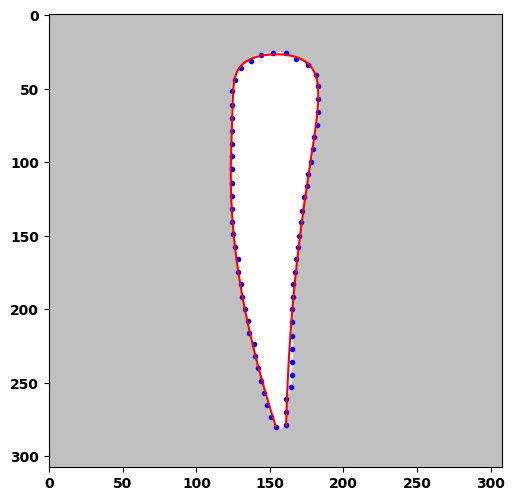

In [15]:
testOF(imgn=3,N=6,mode=0,err_th=0.65)

^^^.^.^.^.^.^..^.^..^..^....................^^.^^^.^^^..^............
CP 5.0, steps:68, etime: 12.12500 err: 4.9908951497
...........^^^^^^^^..^.........
......................^^^^^^.^^^^.^.^....................................^^^^^^^^^^..^..............
................................................^^^^^^^^^^.^^.^.^...................................
...................^^^^^^^^^^^.^.^.^.^.^................................................^^^^^^^^^.^.
^^^.^..^.^..^.^....^....^....^....^..^.^..^................^^^^^^^^.^^^^^^..........................
......................^^^^^...
CP 2.0, steps:529, etime: 77.29688 err: 1.9819318601
.^......^^^^^^^^^^^^^.^.^.^.^.........................................
................................^^^^^^^^^^^^^^^.^.^.^.^.............................................
............................^^^^^^^^^^^^^^^^^^^.^.^.................................................
...................
CP 1.0, steps:818, etime: 116.95312 err: 0.9989368598
..^^^^^^^^^

(1772, 0.485434040981066, array([], dtype=int64))

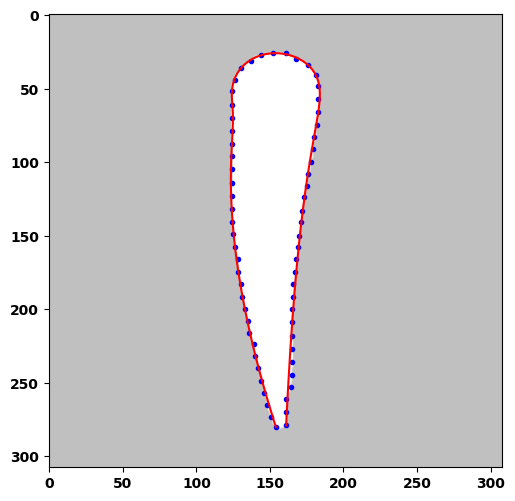

In [77]:
testOF(imgn=3,N=7,mode=0,err_th=0.5,of_th=0.5)

....
CP 5.0, steps:3, etime: 8.12500 err: 4.8370081474
.................
CP 2.0, steps:20, etime: 25.07812 err: 1.9785521570
...................
CP 1.0, steps:39, etime: 44.01562 err: 0.9829298367
.................
CP 0.65, steps:56, etime: 61.18750 err: 0.6409405487
.....................E



(0.4986568086756752, array([], dtype=int64))

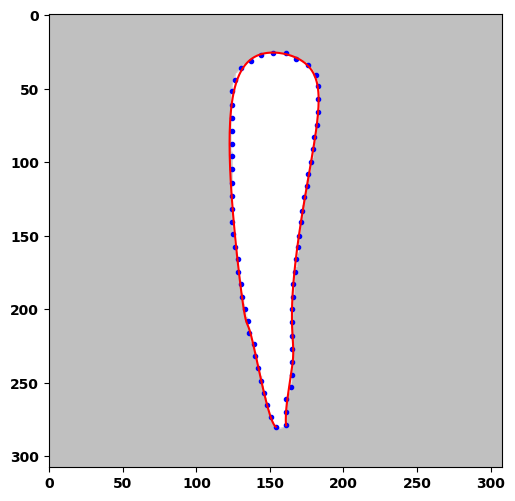

In [10]:
testOF(imgn=3,N=10,mode=1,err_th=0.5)

## img 4

^^^^^^^^.^....^..........................
CP 5.0, steps:40, etime: 14.95312 err: 4.9850102513
..........................................^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........
..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(2.0578811704777245,
 array([52], dtype=int64),
 Matrix([
 [154.0*t**11 + 193.807*t**10*(11 - 11*t) + 12131.5*t**9*(1 - t)**2 - 76359.7*t**8*(1 - t)**3 + 673325.0*t**7*(1 - t)**4 - 1.03016e+6*t**6*(1 - t)**5 + 1.21293e+6*t**5*(1 - t)**6 - 561653.0*t**4*(1 - t)**7 + 132989.0*t**3*(1 - t)**8 - 6503.67*t**2*(1 - t)**9 + 1932.4*t*(1 - t)**10 + 148.0*(1 - t)**11],
 [     280.0*t**11 - 51.8918*t**10*(11 - 11*t) + 14504.4*t**9*(1 - t)**2 + 58883.4*t**8*(1 - t)**3 + 53042.6*t**7*(1 - t)**4 - 335986.0*t**6*(1 - t)**5 + 436735.0*t**5*(1 - t)**6 - 220692.0*t**4*(1 - t)**7 + 18725.8*t**3*(1 - t)**8 + 28952.4*t**2*(1 - t)**9 - 949.617*t*(1 - t)**10 + 279.0*(1 - t)**11]]))

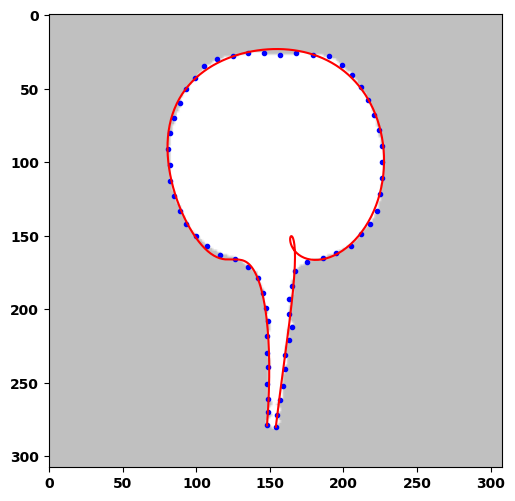

In [45]:
testOF(imgn=4,N=11,mode=0,err_th=1.0,of_th=1.0)

^^^^^^^^.^....^..........................
CP 5.0, steps:40, etime: 14.06250 err: 4.9850102513
..........................................^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........
..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(2857, 650.28125, 2.0578811704777245, array([52], dtype=int64))

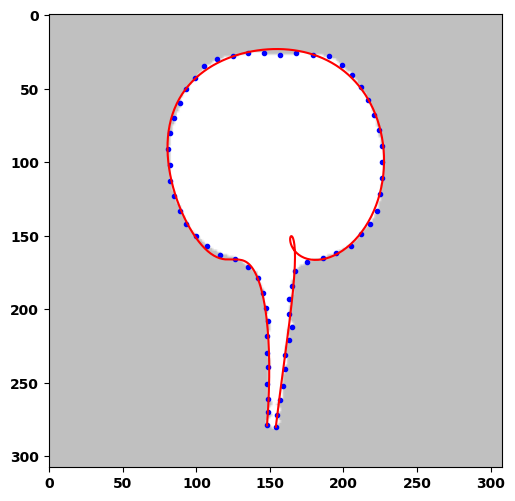

In [25]:
testOF(imgn=4,N=11,mode=0,err_th=1,of_th=1)

^^^^^^^^.^....^..........................
CP 5.0, steps:40, etime: 14.59375 err: 4.9850102513
..........................................^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........
..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(2.0578811704777245,
 array([12, 52], dtype=int64),
 Matrix([
 [154.0*t**11 + 193.807*t**10*(11 - 11*t) + 12131.5*t**9*(1 - t)**2 - 76359.7*t**8*(1 - t)**3 + 673325.0*t**7*(1 - t)**4 - 1.03016e+6*t**6*(1 - t)**5 + 1.21293e+6*t**5*(1 - t)**6 - 561653.0*t**4*(1 - t)**7 + 132989.0*t**3*(1 - t)**8 - 6503.67*t**2*(1 - t)**9 + 1932.4*t*(1 - t)**10 + 148.0*(1 - t)**11],
 [     280.0*t**11 - 51.8918*t**10*(11 - 11*t) + 14504.4*t**9*(1 - t)**2 + 58883.4*t**8*(1 - t)**3 + 53042.6*t**7*(1 - t)**4 - 335986.0*t**6*(1 - t)**5 + 436735.0*t**5*(1 - t)**6 - 220692.0*t**4*(1 - t)**7 + 18725.8*t**3*(1 - t)**8 + 28952.4*t**2*(1 - t)**9 - 949.617*t*(1 - t)**10 + 279.0*(1 - t)**11]]))

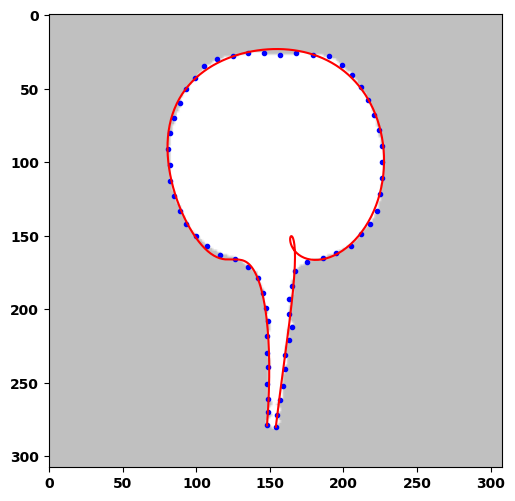

In [60]:
testOF(imgn=4,N=11,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^.^....^..........................
CP 5.0, steps:40, etime: 14.20312 err: 4.9850102513
..........................................^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........
..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(2857, 2.0578811704777245, array([12, 52], dtype=int64))

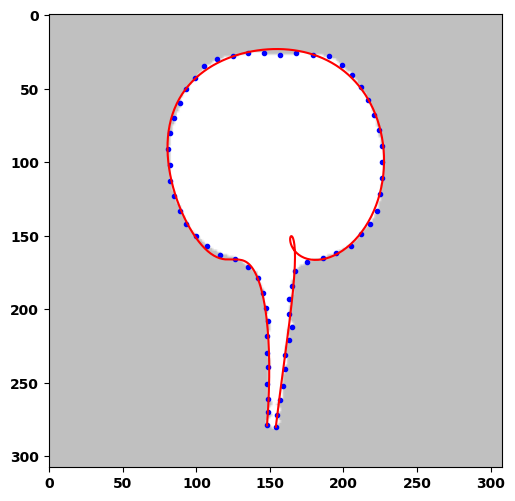

In [8]:
testOF(imgn=4,N=11,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^.^....^..........................
CP 5.0, steps:40, etime: 13.84375 err: 4.9850102513
..........................................^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........
..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(2857, 653.859375, 2.0578811704777245, array([52], dtype=int64))

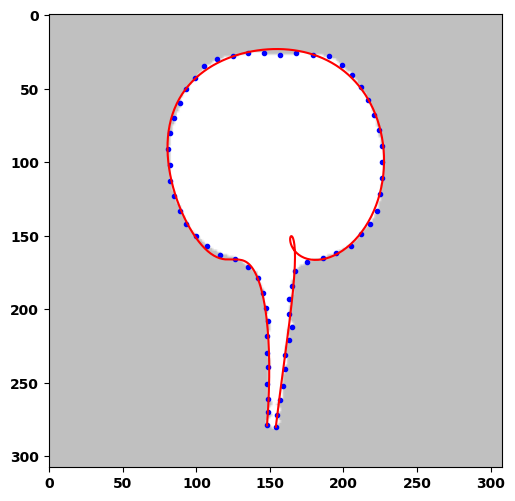

In [9]:
testOF(imgn=4,N=11,mode=0,err_th=0.7,of_th=0.7)

^^^^^^^^^^^^^.^.^.
CP 5.0, steps:17, etime: 9.28125 err: 4.5435643051
^..^.^...............................................................^^^^^..^^^^.^
^^...^^^...^....^....^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 2.0, steps:395, etime: 107.79688 err: 1.9366345086
....
..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^.......^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........^^^^...............^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^............E
[] [array([2.65632788, 2.85355354, 3.12097928])] (array([35, 56, 63], dtype=int64),) span 11.328348133713007


(0.9983760090744074,
 array([], dtype=int64),
 Matrix([
 [             154.0*t**12 + 188.169*t**11*(12 - 12*t) + 12438.1*t**10*(1 - t)**2 - 40229.8*t**9*(1 - t)**3 + 645579.0*t**8*(1 - t)**4 - 612175.0*t**7*(1 - t)**5 + 355019.0*t**6*(1 - t)**6 + 523898.0*t**5*(1 - t)**7 - 340573.0*t**4*(1 - t)**8 + 93514.6*t**3*(1 - t)**9 + 954.542*t**2*(1 - t)**10 + 1966.7*t*(1 - t)**11 + 148.0*(1 - t)**12],
 [280.0*t**12 - 28.7605*t**11*(12 - 12*t) + 42349.4*t**10*(1 - t)**2 - 266047.0*t**9*(1 - t)**3 + 1.84976e+6*t**8*(1 - t)**4 - 5.11924e+6*t**7*(1 - t)**5 + 6.87795e+6*t**6*(1 - t)**6 - 4.67314e+6*t**5*(1 - t)**7 + 1.59572e+6*t**4*(1 - t)**8 - 254741.0*t**3*(1 - t)**9 + 47584.2*t**2*(1 - t)**10 - 863.136*t*(1 - t)**11 + 279.0*(1 - t)**12]]))

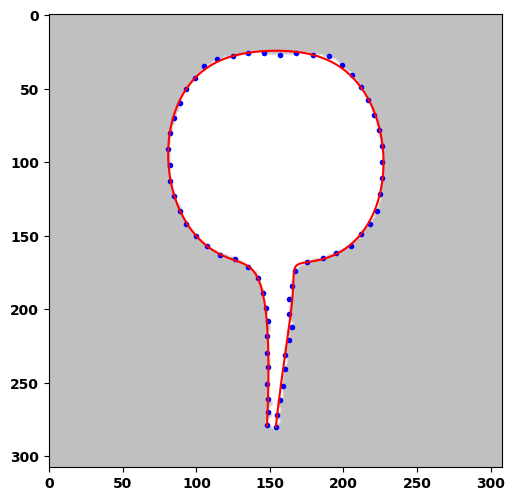

In [46]:
testOF(imgn=4,N=12,mode=0,err_th=1.0,of_th=1.0)

^^^^^^^^^^^^^.^.^.
CP 5.0, steps:17, etime: 9.46875 err: 4.5435643051
^..^.^...............................................................^^^^^..^^^^.^
^^...^^^...^....^....^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 2.0, steps:395, etime: 109.98438 err: 1.9366345086
....
..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^.......^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........^^^^...............^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^............
CP 1.0, steps:572, etime: 157.14062 err: 0.9983760091
..^^..................^^^^^
^^^^^^^^^^^^^^^^^...........^.^^^^^^^^^^^^^^^.^.^.^..^^^^^^^^^^^^^^^^^^^^^^..E

[] [array([3.43656271, 3.09550155])]


(676, 0.6429531235976093, array([], dtype=int64))

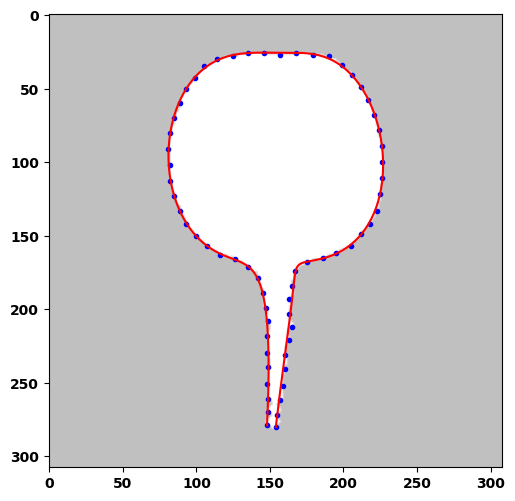

In [74]:
testOF(imgn=4,N=12,mode=0,err_th=0.65,of_th=0.65)

^^^^^^^^^^^^^.^.^.
CP 5.0, steps:17, etime: 9.04688 err: 4.5435643051
^..^.^...............................................................^^^^^..^^^^.^
^^...^^^...^....^....^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 2.0, steps:395, etime: 103.54688 err: 1.9366345086
....
..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^.......^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........^^^^...............^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^............
CP 1.0, steps:572, etime: 148.76562 err: 0.9983760091
..^^..................^^^^^
^^^^^^^^^^^^^^^^^...........^.^^^^^^^^^^^^^^^.^.^.^..^^^^^^^^^^^^^^^^^^^^^^..
CP 0.65, steps:676, etime: 174.34375 err: 0.6429531236
.......................
..........^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......E
[] [array([3.36612793, 3.

(747, 191.828125, 0.49712800549062075, array([], dtype=int64))

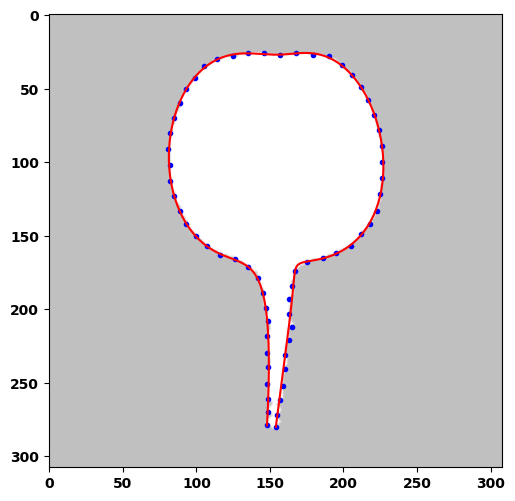

In [23]:
testOF(imgn=4,N=12,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^^^.^.^.
CP 5.0, steps:17, etime: 9.84375 err: 4.5435643051
^..^.^...............................................................^^^^^..^^^^.^
^^...^^^...^....^....^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 2.0, steps:395, etime: 115.67188 err: 1.9366345086
....
..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^.......^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........^^^^...............^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^............
CP 1.0, steps:572, etime: 165.28125 err: 0.9983760091
..^^..................^^^^^
^^^^^^^^^^^^^^^^^...........^.^^^^^^^^^^^^^^^.^.^.^..^^^^^^^^^^^^^^^^^^^^^^..
CP 0.65, steps:676, etime: 194.57812 err: 0.6429531236
.......................
..........^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......E
[] [array([3.36612793, 3.

(0.49712800549062075,
 array([], dtype=int64),
 Matrix([
 [              154.0*t**12 + 198.351*t**11*(12 - 12*t) + 8391.5*t**10*(1 - t)**2 + 2335.7*t**9*(1 - t)**3 + 594838.0*t**8*(1 - t)**4 - 719038.0*t**7*(1 - t)**5 + 383639.0*t**6*(1 - t)**6 + 609163.0*t**5*(1 - t)**7 - 310797.0*t**4*(1 - t)**8 + 79418.7*t**3*(1 - t)**9 - 1359.03*t**2*(1 - t)**10 + 2022.71*t*(1 - t)**11 + 148.0*(1 - t)**12],
 [280.0*t**12 - 69.9109*t**11*(12 - 12*t) + 47108.8*t**10*(1 - t)**2 - 267472.0*t**9*(1 - t)**3 + 1.77716e+6*t**8*(1 - t)**4 - 5.14429e+6*t**7*(1 - t)**5 + 7.01201e+6*t**6*(1 - t)**6 - 4.61452e+6*t**5*(1 - t)**7 + 1.52792e+6*t**4*(1 - t)**8 - 280586.0*t**3*(1 - t)**9 + 54170.9*t**2*(1 - t)**10 - 1326.37*t*(1 - t)**11 + 279.0*(1 - t)**12]]))

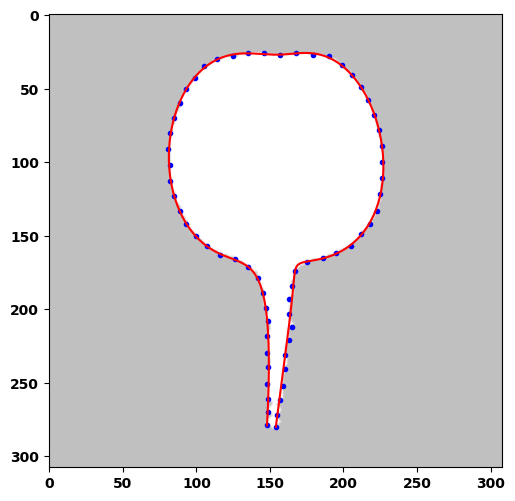

In [59]:
testOF(imgn=4,N=12,mode=0,err_th=0.5,of_th=0.5)

## img 5

^^^^^^^.^^^^.^.
CP 5.0, steps:14, etime: 6.93750 err: 3.5340520569
^^^^.^^.^^.^^.^.........................^^^^^^^^^^^^^^^^^^^^^^^^^....................
............^^^^^^^^^^^^.^^^.^....................................^^^^^^^^^^^^^.^^.^...........
CP 2.0, steps:194, etime: 42.07812 err: 1.9980757171
.....
..............................^^^^^^^^^^^^^^^.^...^.................................................
.^^^^^^^^^^^^^^^^^^...........................................................^^^^^^^^^^^^^^^^.^.^.^
...^..........................................^^^^^^^^^^^^^^^^^^^^^.......^.........................
.................^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
.^^^^.^.^.^.^^^.^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^..^.^^.^.^.^^^^.^.^.^^^
^.^.^.^.^..^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.9957592178508918,
 array([], dtype=int64),
 Matrix([
 [156.0*t**9 + 140.714*t**8*(9 - 9*t) + 21009.7*t**7*(1 - t)**2 - 65977.7*t**6*(1 - t)**3 + 240846.0*t**5*(1 - t)**4 - 206140.0*t**4*(1 - t)**5 + 97125.6*t**3*(1 - t)**6 - 11415.0*t**2*(1 - t)**7 + 1510.31*t*(1 - t)**8 + 150.0*(1 - t)**9],
 [  279.0*t**9 + 189.999*t**8*(9 - 9*t) + 12030.1*t**7*(1 - t)**2 - 17781.1*t**6*(1 - t)**3 + 10086.5*t**5*(1 - t)**4 + 5640.72*t**4*(1 - t)**5 - 9096.02*t**3*(1 - t)**6 + 8138.96*t**2*(1 - t)**7 + 1737.99*t*(1 - t)**8 + 279.0*(1 - t)**9]]))

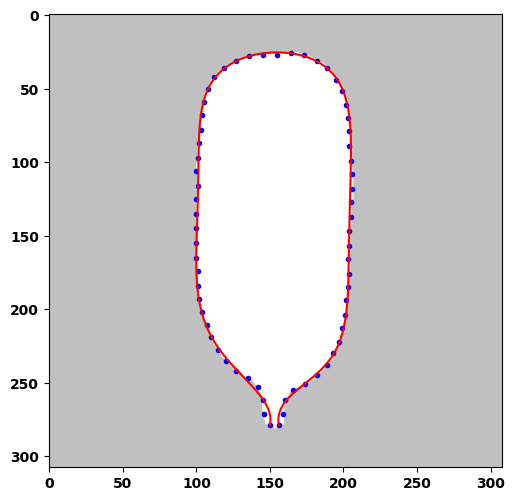

In [49]:
testOF(imgn=5,N=9,mode=0,err_th=1.0,of_th=1.0)

^^^^^^^.^^^^.^.
CP 5.0, steps:14, etime: 6.87500 err: 3.5340520569
^^^^.^^.^^.^^.^.........................^^^^^^^^^^^^^^^^^^^^^^^^^....................
............^^^^^^^^^^^^.^^^.^....................................^^^^^^^^^^^^^.^^.^...........
CP 2.0, steps:194, etime: 41.50000 err: 1.9980757171
.....
..............................^^^^^^^^^^^^^^^.^...^.................................................
.^^^^^^^^^^^^^^^^^^...........................................................^^^^^^^^^^^^^^^^.^.^.^
...^..........................................^^^^^^^^^^^^^^^^^^^^^.......^.........................
.................^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
.^^^^.^.^.^.^^^.^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^..^.^^.^.^.^^^^.^.^.^^^
^.^.^.^.^..^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.4984326518582984,
 array([], dtype=int64),
 Matrix([
 [156.0*t**9 + 156.515*t**8*(9 - 9*t) + 16958.9*t**7*(1 - t)**2 - 39203.1*t**6*(1 - t)**3 + 175107.0*t**5*(1 - t)**4 - 141973.0*t**4*(1 - t)**5 + 71129.4*t**3*(1 - t)**6 - 7203.9*t**2*(1 - t)**7 + 1306.44*t*(1 - t)**8 + 150.0*(1 - t)**9],
 [ 279.0*t**9 + 165.159*t**8*(9 - 9*t) + 17057.5*t**7*(1 - t)**2 - 36972.7*t**6*(1 - t)**3 + 19726.7*t**5*(1 - t)**4 + 29534.6*t**4*(1 - t)**5 - 33726.1*t**3*(1 - t)**6 + 14212.1*t**2*(1 - t)**7 + 1409.92*t*(1 - t)**8 + 279.0*(1 - t)**9]]))

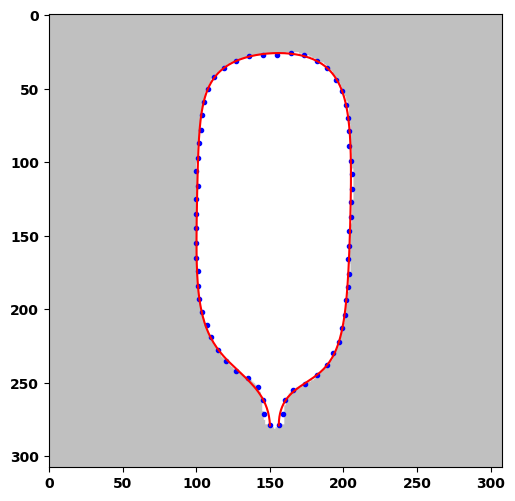

In [57]:
testOF(imgn=5,N=9,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^^^^.^.
CP 5.0, steps:16, etime: 8.01562 err: 4.7534996104
^^.^^.^^.^.........................................................................
....................................................................................................
..................^^^^^^^^^^^^^^.
CP 2.0, steps:232, etime: 56.20312 err: 1.9828193016
....^..........................................^^^^^^^^^^^^^^^.....
.....................................................^^^^^^^^^^^^^^^^^.....^........................
.........................^^^^^^^^^^^^^^^^.^....^.^...........................................^^^^^^^
^^^^^^^^^^^^^^.^.^^^^^^.^.^^^^^^.^^^^^^^^.^.^.^^^.^^^^^^.^.^.^.^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^.^^^^
.^.^.
CP 1.0, steps:704, etime: 161.00000 err: 0.9988589652
^^^^^^^^^^^^.^.^.^.^.^.^^^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.49757945613396715,
 array([], dtype=int64),
 Matrix([
 [ 156.0*t**10 + 161.031*t**9*(10 - 10*t) + 19997.6*t**8*(1 - t)**2 - 38398.5*t**7*(1 - t)**3 + 191413.0*t**6*(1 - t)**4 - 52897.4*t**5*(1 - t)**5 - 18203.0*t**4*(1 - t)**6 + 49893.1*t**3*(1 - t)**7 - 4070.95*t**2*(1 - t)**8 + 1340.12*t*(1 - t)**9 + 150.0*(1 - t)**10],
 [279.0*t**10 + 158.23*t**9*(10 - 10*t) + 23911.1*t**8*(1 - t)**2 - 90492.5*t**7*(1 - t)**3 + 215286.0*t**6*(1 - t)**4 - 285803.0*t**5*(1 - t)**5 + 225326.0*t**4*(1 - t)**6 - 87328.0*t**3*(1 - t)**7 + 22283.2*t**2*(1 - t)**8 + 1449.27*t*(1 - t)**9 + 279.0*(1 - t)**10]]))

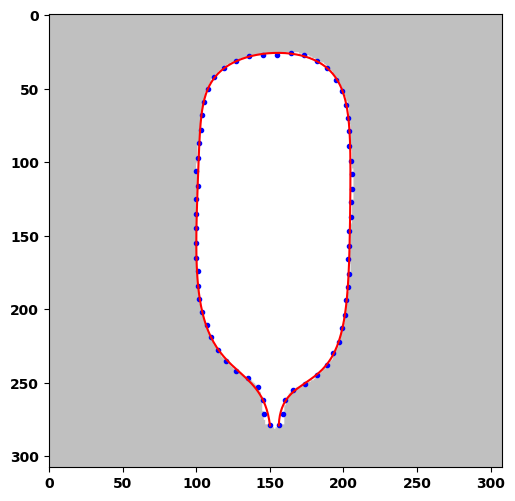

In [50]:
testOF(imgn=5,N=10,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^
CP 5.0, steps:7, etime: 6.14062 err: 4.0594037783
^^^^^^^^.^^^^.
CP 2.0, steps:21, etime: 9.23438 err: 1.8333705253
^^.^^.^.......................................................................
......................................................................^^^^^^^^^^^^^^................
........................^^^^^^^^^^^.^.^...................................^^^^^^^^^^^^.^.E



(0.999832115165081, array([], dtype=int64))

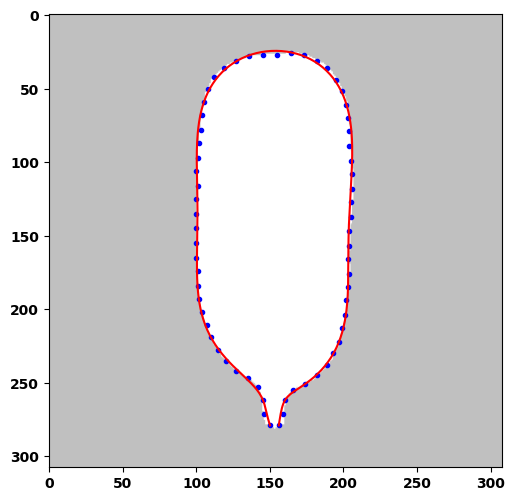

In [52]:
testOF(imgn=5,N=11,mode=0,err_th=1)

## img 6

^^^^^e1.e1^.^.^..^.^.^^.^..^...................................................................
CP 5.0, steps:90, etime: 22.82812 err: 4.9955644639
.........
....................................................................................................
...................^^^^^^^^^^^^^...................................................^^^^^^^^^^^^.^...
..............................................^^^^^^^^^^^^^^........................................
...............^^^^^^^^^^^^^^.^................................................^^^^^^^^^^^^^^^^^.^.^
.^.^.^.^..^.^.^.^......................................^^^^^^^^^^^^^.^.^^^^^^.^.^.^.
CP 2.0, steps:583, etime: 122.07812 err: 1.9971751229
^.^.^^^^.^.^.^.^
.^^^^^^.^.^^^^^^^^^^^.^....^.^.^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^
.^.^.^^^^^^^^^^^^^^^.^.^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^
.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 612.75, 1.1447108737806566, array([62, 63], dtype=int64))

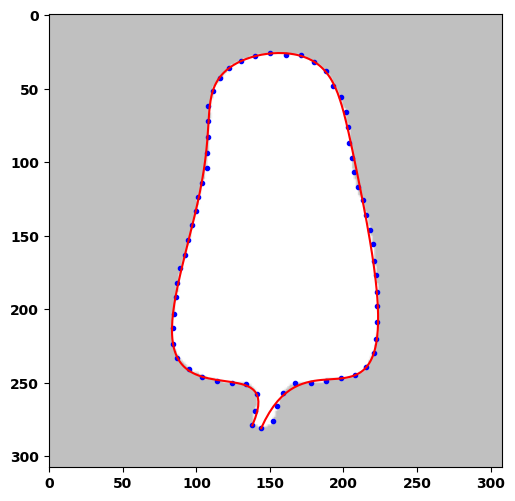

In [29]:
testOF(imgn=6,N=10,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^.^..^.^..^.
CP 5.0, steps:21, etime: 9.60938 err: 4.6200057650
^^.^..........................................................................
.......................................................................^^^^^.^^...^.................
........................^^^^^^^^^.
CP 2.0, steps:233, etime: 59.81250 err: 1.9899104783
^........................................^^^^^^^^^^.^.^...........
..........................^^^^^^^^^^.^.^....^...............................^^^^^^^^.^^^^^^.^..^....
^^^^^^^^^^..^^......................^^^^^^^^^^^^^^^^^^^^^^^^....................^.^.^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^.^.^.^.^^^^^.^^^.^.....^.^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^.^^^^^^^^^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 699.828125, 1.0234006592188545, array([ 2, 63], dtype=int64))

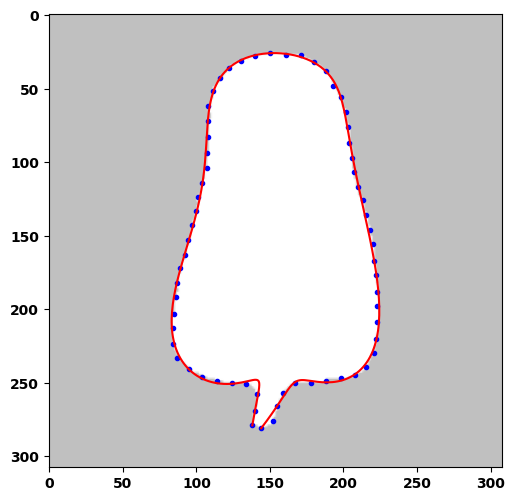

In [30]:
testOF(imgn=6,N=11,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^.^..^.^..^.
CP 5.0, steps:21, etime: 10.00000 err: 4.6200057650
^^.^..........................................................................
.......................................................................^^^^^.^^...^.................
........................^^^^^^^^^.
CP 2.0, steps:233, etime: 63.64062 err: 1.9899104783
^........................................^^^^^^^^^^.^.^...........
..........................^^^^^^^^^^.^.^....^...............................^^^^^^^^.^^^^^^.^..^....
^^^^^^^^^^..^^......................^^^^^^^^^^^^^^^^^^^^^^^^....................^.^.^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^.^.^.^.^^^^^.^^^.^.....^.^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^.^^^^^^^^^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.9996541491958801,
 array([2], dtype=int64),
 Matrix([
 [144.0*t**11 + 265.422*t**10*(11 - 11*t) - 15180.3*t**9*(1 - t)**2 + 375682.0*t**8*(1 - t)**3 - 1.4383e+6*t**7*(1 - t)**4 + 3.10571e+6*t**6*(1 - t)**5 - 2.76758e+6*t**5*(1 - t)**6 + 1.21192e+6*t**4*(1 - t)**7 - 169854.0*t**3*(1 - t)**8 + 5671.96*t**2*(1 - t)**9 + 1887.07*t*(1 - t)**10 + 138.0*(1 - t)**11],
 [     281.0*t**11 + 124.03*t**10*(11 - 11*t) + 29736.8*t**9*(1 - t)**2 + 24965.8*t**8*(1 - t)**3 - 364677.0*t**7*(1 - t)**4 + 1.05125e+6*t**6*(1 - t)**5 - 1.32609e+6*t**5*(1 - t)**6 + 828733.0*t**4*(1 - t)**7 - 245861.0*t**3*(1 - t)**8 + 52202.1*t**2*(1 - t)**9 + 845.447*t*(1 - t)**10 + 279.0*(1 - t)**11]]))

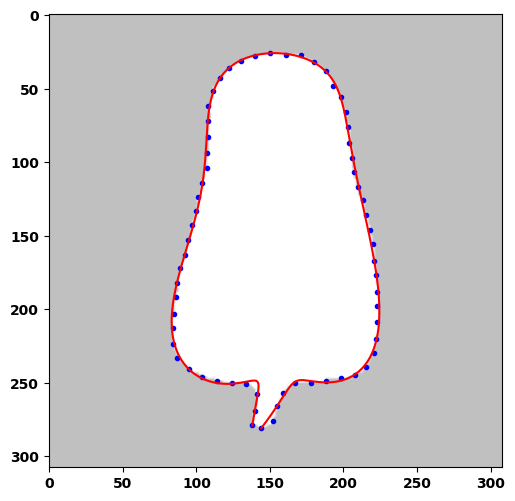

In [42]:
testOF(imgn=6,N=11,mode=0,err_th=1,of_th=1.0)

^^^^^^^^^^^^^^^^.
CP 5.0, steps:16, etime: 9.20312 err: 4.2182865223
^^.^.^^........................^..^^^.......................^^^^...................
...^^^............
CP 2.0, steps:117, etime: 35.23438 err: 1.9995161449
............^^^...^^................^^^...^^.......................^^^^...^^.....^
^^^^^^.^.^.........^^^^^^..^..........................^^^^^^^^^^^^^.
CP 1.0, steps:267, etime: 73.46875 err: 0.9893683434
............................^^^^
^^^^^^^^^^^^^^^^^^^^..^....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^.........
CP 0.65, steps:417, etime: 112.07812 err: 0.6493791079
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^.^.^.^^^^^^^^.^.^.^.^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.4974116872899298,
 array([], dtype=int64),
 Matrix([
 [    144.0*t**12 + 221.658*t**11*(12 - 12*t) - 9171.79*t**10*(1 - t)**2 + 343300.0*t**9*(1 - t)**3 - 958474.0*t**8*(1 - t)**4 + 1.31177e+6*t**7*(1 - t)**5 + 905752.0*t**6*(1 - t)**6 - 1.89906e+6*t**5*(1 - t)**7 + 1.07661e+6*t**4*(1 - t)**8 - 137792.0*t**3*(1 - t)**9 + 3191.52*t**2*(1 - t)**10 + 2018.01*t*(1 - t)**11 + 138.0*(1 - t)**12],
 [281.0*t**12 + 247.079*t**11*(12 - 12*t) - 9287.91*t**10*(1 - t)**2 + 501417.0*t**9*(1 - t)**3 - 2.60804e+6*t**8*(1 - t)**4 + 6.61875e+6*t**7*(1 - t)**5 - 8.46225e+6*t**6*(1 - t)**6 + 5.51136e+6*t**5*(1 - t)**7 - 1.67725e+6*t**4*(1 - t)**8 + 203335.0*t**3*(1 - t)**9 + 20374.2*t**2*(1 - t)**10 + 2067.78*t*(1 - t)**11 + 279.0*(1 - t)**12]]))

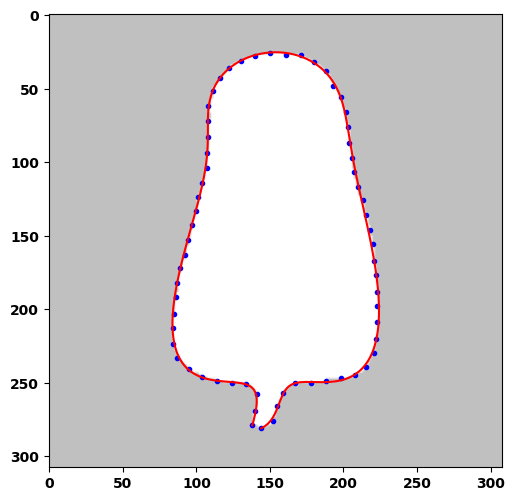

In [12]:
testOF(imgn=6,N=12,mode=0,err_th=0.5,pat=1500)

^^^^^^^^^^^^^^^^.
CP 5.0, steps:16, etime: 8.85938 err: 4.2182865223
^^.^.^^........................^..^^^.......................^^^^...................
...^^^............
CP 2.0, steps:117, etime: 33.90625 err: 1.9995161449
............^^^...^^................^^^...^^.......................^^^^...^^.....^
^^^^^^.^.^.........^^^^^^..^..........................^^^^^^^^^^^^^.
CP 1.0, steps:267, etime: 72.04688 err: 0.9893683434
............................^^^^
^^^^^^^^^^^^^^^^^^^^..^....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^.........
CP 0.65, steps:417, etime: 110.03125 err: 0.6493791079
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^.^.^.^^^^^^^^.^.^.^.^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 752.9375, 0.5009132244540628, array([], dtype=int64))

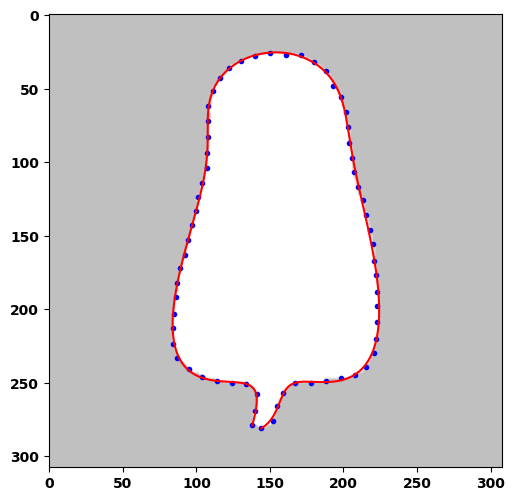

In [31]:
testOF(imgn=6,N=12,mode=0,err_th=0.5,of_th=0.5)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 10.09375 err: 4.7102547081
^.^^.^.....^.....................
CP 2.0, steps:47, etime: 21.14062 err: 1.9934006401
...................^^^..^^^^^^^....................^
^^..^^^^^^^....................^^^^..^^^^.^^^^^^^.^.^...........^^^^^..^^^..^..............^^^^^.^^^
^^^^^..^^...^......E

[] [array([2.19933168, 2.13200713, 3.80335013])]


(0.999650046406839, array([], dtype=int64))

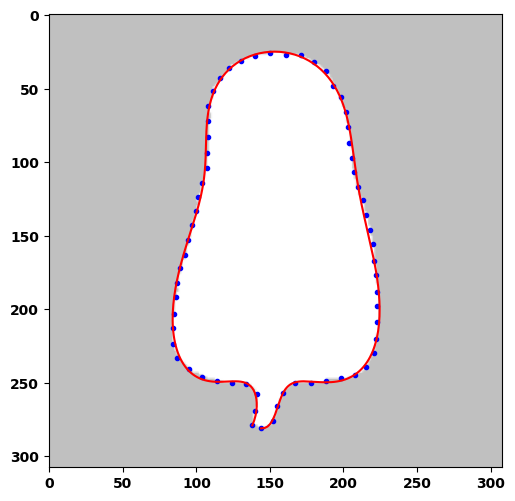

In [34]:
testOF(imgn=6,N=14,mode=0,err_th=1)

## img 7

^^^^^^^.^.^.^..
CP 5.0, steps:14, etime: 3.54688 err: 4.5679356486
.....
CP 2.0, steps:19, etime: 4.14062 err: 1.6232158622
^..^..^..^^..^................................................................^^
^^^^^^^^^^^^^........................................^^^^^^^^^^^^^^^^^^......................E

[] [array([2.87096966, 2.08382473, 2.2637717 , 2.82671291])]


(0.9993519811648999, array([], dtype=int64))

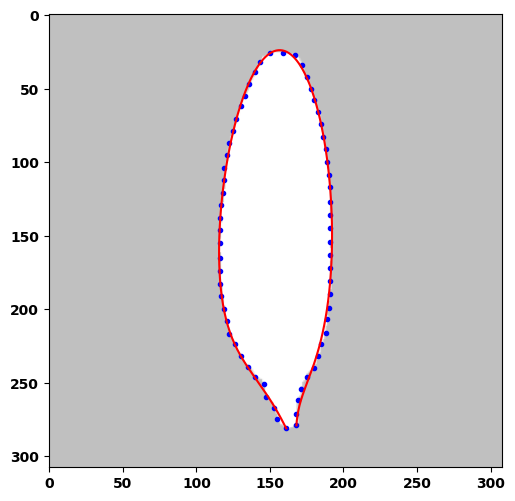

In [33]:
testOF(imgn=7,N=6,mode=0,err_th=1)

## img 8

^^^^^^^^^.^.^....^..................................................................................
......
CP 5.0, steps:105, etime: 20.15625 err: 4.9971788256
...................................................^^^^^^^^^^^^^.^............................
......................^^^^^^.^^.^^.^....^..............................................^^^^^^^^^^^^^
.^^.^.^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^.^.^.^.^.^.......................^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^........^..^..^..^.^..^..........^^^^^^^^^^^^^^^^^^^^^..^.^^.^^^^^^^^^^^^
^^^^^^.^^^^^.^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^^..^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^.^^..^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^..^^.^
^..^^^^^^.^^.^^..^^.^^.^^^^^^^^^^^^^^^^^^^^^^^..^^^...^^^^^^^^^^^^^^^^^^^^.^^^^^^.^^^.^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^..^^^^.^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1.6454392501962782, array([23], dtype=int64))

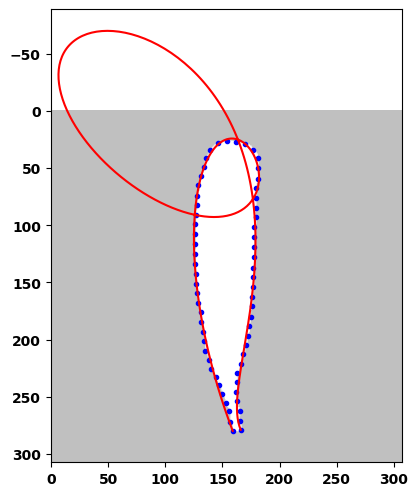

In [7]:
testOF(imgn=8,N=8,mode=0,err_th=0.5,of_th=0.5)

# fit1T mode1 special

fit1T mode 1 は他と比べて　1ステップ当たりの動きが少ない。おおむね1/3～1/4でしかない。
そのことを考慮して、収束判定を特別扱いする必要がある。下のコードでは打ち切りステップ数を6000としている。

In [15]:
# fitT0 special 
def testOF0(imgn=0,N=7,lr=0.001,lrP=30000,pat=2000,maxTry=6000,mode=1,err_th=1.0,of_th=1.0):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    start = time.process_time()
    cps, func,(err,trynum) = bez.fit1T(tpara=[],mode=mode,maxTry=maxTry,err_th=err_th,lr=lr,lrP=lrP,pat=pat,withErr=True,withEC=True)
    etime = time.process_time() - start
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return trynum,etime,err,isOverFitting3(func,bez.ts,conAll,of_th=of_th)

^^^^^^^^^.^.^^.^.^..^................................
CP 5.0, steps:52, etime: 15.23438 err: 4.9777140652
...............................................
.....................^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.....................................................^^^^^^^^....................^^^^^^^^^
^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(6000, 1224.140625, 1.9333208345979551, array([52], dtype=int64))

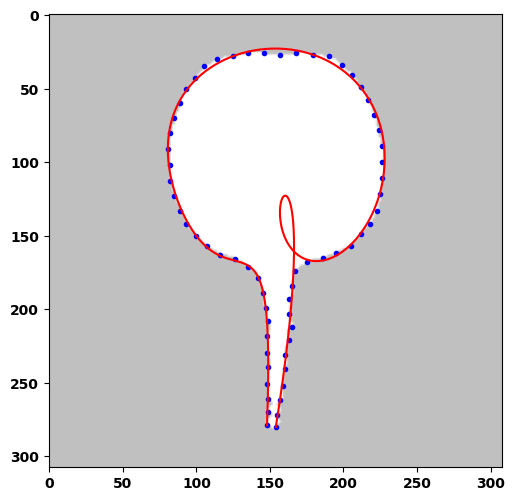

In [16]:
testOF0(imgn=4,N=10,mode=0,err_th=1.0,of_th=1.0)